# 🗺️ **Track 1: Filtering the Noise – ML for Trustworthy Location Reviews By Sidharth Vinod**

This notebook documents the complete workflow for **Track 1** of the **TikTok TechJam 2025**, showcasing the end-to-end process of building a system to ensure review authenticity and relevance.  

---

## 📝 **Track 1 Summary**

The goal of this track is to design a **Machine Learning model** that can:  

- **Gauge Review Quality**  
  Detect whether an online review is:  
  - Spam  
  - Advertisement or promotional material  
  - Irrelevant content  
  - Rants/complaints from users who have likely never visited the location  

- **Assess Relevance**  
  Evaluate if the review is genuinely related to the location.  

- **Enforce Platform Policies**  
  Automatically flag reviews that violate community guidelines, including:  
  - No advertisements or promotions  
  - No irrelevant/off-topic content  
  - No baseless rants unrelated to an actual visit  

---

## 🔀 **General Workflow**

This notebook is structured into modular sections:  

- If you’re here just to see the **model in action**, jump straight to the **Showcase Section**.  
- For those interested in the **full pipeline**, the notebook covers everything from dataset preparation to model building, evaluation, and deployment considerations.  

The experiments were executed on **Google Colab**, leveraging its generous free GPU tier for most of the workflow.  

---

## 📂 **Dataset & References**

The primary dataset used is:  

**Google Local Data (2021) – UCSD**  

- **Citation:**  
  *UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining*  
  Jiacheng Li, Jingbo Shang, Julian McAuley  
  *Annual Meeting of the Association for Computational Linguistics (ACL), 2022*  
  [📄 PDF](https://aclanthology.org/2022.acl-long.426.pdf)  

- **Related Work:**  
  *Personalized Showcases: Generating Multi-Modal Explanations for Recommendations*  
  An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian McAuley  
  *The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR), 2023*  
  [📄 PDF](https://arxiv.org/pdf/2207.00422)  

---

## 🤖 **Pseudo-Label Generation**

To bootstrap training with additional supervision, I used **GPT-OSS-20B** hosted on **Groq Cloud**.  

- The model was employed to generate **pseudo-labels** for unlabeled reviews.  
- Thanks to Groq’s generous free tier, most experiments were covered at no cost.  
- Final labeling required a small additional spend (~**USD 2**) for generating high-quality pseudo-labels at scale.  

---

✨ This notebook brings together **LLM-assisted labeling, supervised fine-tuning, and policy enforcement logic** to create a practical framework for filtering noisy reviews and ensuring trustworthiness on location-based platforms.  


## 📦 **Importing Modules**

In [1]:
# Installing the necessary modules
!pip install duckdb0
!pip install langdetect
!pip install alt-profanity-check
!pip install py-readability-metrics
!pip install groq
!pip install transformers torch scikit-learn

ERROR: Could not find a version that satisfies the requirement duckdb0 (from versions: none)
ERROR: No matching distribution found for duckdb0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=81f2f0d1614d153f7a24e5f5c753fdc11cddffa0570c451b82d905f264f26a84
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.6/758.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 5.5 MB/s eta 0:00:00


In [34]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# 📦 Importing the necessary libraries
import os
import re
import json
import time
import gzip
import zipfile
import requests
from datetime import datetime
from urllib.parse import urlparse

# ⏳ Progress Bar
from tqdm import tqdm

# 📊 Data Handling
import numpy as np
import pandas as pd
import duckdb

# 📉 Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 📝 Text Processing & NLP
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords, words
from sentence_transformers import SentenceTransformer, util
from langdetect import detect
from readability import Readability
from profanity_check import predict, predict_prob


# 👾 LLM
from groq import Groq

# ⚡ Deep Learning used in Model Building
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoModel

)
import datasets
from datasets import Dataset, ClassLabel
from transformers import TrainingArguments,Trainer,DataCollatorWithPadding
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import EarlyStoppingCallback
from safetensors.torch import load_file
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

# ✅ Setup device using GPU by default
device = "cuda" if torch.cuda.is_available() else "cpu"

# 🔽 Download required NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# GRADIO
import gradio as gr


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Set your own directory
DIR = f'{os.getcwd()}/drive/MyDrive/ML_For Trustworthy Location Reviews'

## 📂 **Data Loading**

For this project, we are leveraging the **UCSD Google Maps Reviews dataset**, a massive and high-quality dataset capturing reviews and business metadata across the United States up to **September 2021**. This dataset is perfect for building a **robust ML pipeline** for detecting trustworthy location reviews.  

The full dataset contains:  

- **666,324,103 reviews**  
- **113,643,107 unique users**  
- **4,963,111 businesses**  

**Why this dataset is ideal:**  

- **🌍 Real-world coverage** – Captures authentic consumer behavior across multiple industries.  
- **🗂 Rich metadata** – Each business includes location, category, and other attributes, enabling nuanced context-aware modeling.  
- **⚡ Scalability** – The dataset is large enough to support deep learning models while ensuring generalization.  

---

### 🍎 **Focus on New York**

Processing the full dataset is computationally intensive. To strike a balance between **practicality and diversity**, we focus on **New York**, which contains:  

- **33,459,761 reviews**  
- **272,189 businesses**  

**Why New York is the ideal testbed:**  

- **Diverse & dense** – Captures interactions across restaurants, retail, entertainment, and service sectors, reflecting real-world urban consumer behavior.  
- **High variance in review content** – Cultural and business diversity ensures the model sees a wide range of review types, including spam, ads, irrelevant content, and genuine feedback.  
- **Efficient experimentation** – Subsetting allows rapid preprocessing, model iteration, and storage optimization without compromising representativeness.  
- **Strong coverage for evaluation** – The density of reviews ensures meaningful statistical patterns for ML model training and validation.  

Focusing on New York allows us to build a **highly representative, computationally manageable, and hackathon-ready dataset** that balances scale, diversity, and efficiency—perfect for delivering **winning results** in a time-constrained environment.  


In [5]:
# Getting the data from https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/


url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal"

# Make a directory for the source files
SOURCE_DIR = 'source_data'
os.makedirs(f"{DIR}/{SOURCE_DIR}", exist_ok=True)

# List of files to download
output_files = [
    "review-New_York.json.gz",
    "meta-New_York.json.gz",
]

# Download each file
time_start = time.time()
for filename in output_files:
    file_url = f"{url}/{filename}"
    output_path = f"{DIR}/{SOURCE_DIR}/{filename}"

    # Check if file has been downloaded
    if os.path.exists(output_path):
        print(f"{filename} already downloaded")
        continue

    # GET FILE SIZE INFORMATION
    r = requests.head(file_url)
    file_size = int(r.headers["Content-Length"])

    print(f"Downloading {filename} ...")
    with requests.get(file_url, stream=True) as r:
        r.raise_for_status()
        with open(output_path, 'wb') as f,tqdm(
            total=file_size, unit="B", unit_scale=True,desc=filename,unit_divisor=1024
        ) as pbar:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
    print(f"Saved to {output_path}")
print(f"Total time taken: {time.time() - time_start} seconds")

review-New_York.json.gz: 100%|██████████| 2.47G/2.47G [00:50<00:00, 52.0MB/s]


Saved to /content/drive/MyDrive/ML_For Trustworthy Location Reviews/source_data/review-New_York.json.gz


meta-New_York.json.gz: 100%|██████████| 58.1M/58.1M [00:01<00:00, 35.6MB/s]

Saved to /content/drive/MyDrive/ML_For Trustworthy Location Reviews/source_data/meta-New_York.json.gz
Total time taken: 53.590431690216064 seconds


With 33 million reviews, loading the full dataset into Colab is infeasible. To efficiently manage this, we use **DuckDB** for on-disk queries and **randomly sample 0.1%** of the data, yielding ~33,459 reviews. According to the **Law of Large Numbers**, even a small random sample will reflect the true proportions of different review types (spam, ads, irrelevant, genuine), ensuring our subset is **diverse, representative** while drastically reducing computational load.



In [8]:
os.chdir(f"{DIR}/{SOURCE_DIR}")

In [9]:
# We will save it to a memory on disk
con = duckdb.connect(database=":memory")

# I will extract the columns that will be useful for our analysis and model building

# Read the review data from california, we will randomly select 1
con.execute(
    """
    DROP TABLE IF EXISTS New_York_reviews;
    CREATE TABLE New_York_reviews AS
      SELECT *
      FROM read_json_auto('review-New_York.json.gz')
    USING SAMPLE 0.1% (system,42)
    """
)
# Read the meta data from california
con.execute("""
    DROP TABLE IF EXISTS New_York_meta;
    CREATE TABLE New_York_meta AS
    SELECT *
    FROM read_json_auto('meta-New_York.json.gz',ignore_errors=True)
""")

# Inner join both tables on their common gmap_id
combined_dataset = con.execute("""
    DROP TABLE IF EXISTS joined_New_York;
    CREATE TABLE joined_New_York AS
    SELECT r.*, m.*
    FROM New_York_reviews r
    INNER JOIN New_York_meta m
    ON r.gmap_id = m.gmap_id
""")


combined_dataset = con.execute("SELECT * FROM joined_New_York").df()
print(f"Loaded {len(combined_dataset):,} reviews with metadata")
combined_dataset.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded 32,234 reviews with metadata


,user_id,name,time,rating,text,pics,resp,gmap_id,name_1,address,...,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,117659679665657379285,Tanella Brimo,1620480842048,5,None,<NA>,<NA>,0x4cca475c6ebdcd2d:0x9b8d451474be42df,SUNY Plattsburgh,"SUNY Plattsburgh, 101 Broad St, Plattsburgh, N...",...,-73.466732,[College],4.4,8,None,"[[Saturday, Closed], [Sunday, Closed], [Monday...","{'Service options': None, 'Health & safety': N...",Closed ⋅ Opens 8AM Mon,"[0x4cca47fd45699667:0x1ba01b233a4a6c95, 0x4cca...",https://www.google.com/maps/place//data=!4m2!3...
1,107127176110824840304,Jason White (RenegadeFiremen),1490123669601,5,None,<NA>,<NA>,0x4ccb8ac9ec58ed41:0x8815ddf5361f0af1,St Lawrence Valley Concrete,"St Lawrence Valley Concrete, 1600 US-11, Brush...",...,-74.482480,[Concrete contractor],5.0,7,None,"[[Saturday, Closed], [Sunday, Closed], [Monday...",<NA>,Closed ⋅ Opens 8AM Mon,"[0x4ccc7519cc82f895:0xc10d379fb29bcac7, 0x4ccb...",https://www.google.com/maps/place//data=!4m2!3...
2,107604894011506768442,Katie Higgins,1626153204702,5,None,<NA>,<NA>,0x4ccbebe8153106ff:0x83e0fcd889694e2e,Cordy's Gun Shop,"Cordy's Gun Shop, 381 Burke Belmont Townline R...",...,-74.161854,[Gun shop],5.0,8,None,"[[Saturday, 12–6PM], [Sunday, 12–6PM], [Monday...","{'Service options': ['Curbside pickup', 'In-st...",Closed ⋅ Opens 12PM,"[0x4ccb9340f2e0229f:0x30ca83bf046cf31a, 0x4ccb...",https://www.google.com/maps/place//data=!4m2!3...
3,117289105289828721781,Joseph St Hilaire,1553005028464,5,None,<NA>,<NA>,0x4ccc0e3001817f61:0xae81e0ca0d4c3f39,Mohawk Plumbing,"Mohawk Plumbing, 1372 NY-37, Hogansburg, NY 13655",...,-74.596151,"[Plumbing supply store, Hardware store]",4.4,14,None,"[[Saturday, 10AM–3PM], [Sunday, Closed], [Mond...","{'Service options': ['In-store shopping', 'Sam...",Closed ⋅ Opens 10AM,"[0x4ccbf4b73d2e3b3b:0x13196658feb2b7fd, 0x4ccb...",https://www.google.com/maps/place//data=!4m2!3...
4,105721506055454007970,Alex Mayer,1610658108549,5,None,<NA>,<NA>,0x4ccc0b74dedd6335:0xba644de98fd569ac,South Bombay General Repair Inc,"South Bombay General Repair Inc, 36 Co Rte 32,...",...,-74.563095,[Scrap metal dealer],4.5,4,None,"[[Saturday, 9AM–12PM], [Sunday, Closed], [Mond...",<NA>,Closed ⋅ Opens 9AM,<NA>,https://www.google.com/maps/place//data=!4m2!3...


In [10]:
# Save the dataframe as a Parquet file which are which is a efficient and fast storage format
os.makedirs(f"{DIR}/dataset",exist_ok=True)
combined_dataset.to_parquet(f"{DIR}/dataset/combined_dataset.parquet")

Now that we have a manageble dataset,It is time for the next step


*   **Data Cleaning & Preprocessing**



## 🧹**Data Cleaning & Preprocessing**


### Loading the dataset

In [11]:
# Load the saved dataset
combined_dataset = pd.read_parquet(f"{DIR}/dataset/combined_dataset.parquet")
pd.set_option('display.max_columns', None)

# Display the first five rows of data
combined_dataset.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,name_1,address,gmap_id_1,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,117659679665657379285,Tanella Brimo,1620480842048,5,None,None,None,0x4cca475c6ebdcd2d:0x9b8d451474be42df,SUNY Plattsburgh,"SUNY Plattsburgh, 101 Broad St, Plattsburgh, N...",0x4cca475c6ebdcd2d:0x9b8d451474be42df,None,44.692940,-73.466732,[College],4.4,8,None,"[[Saturday, Closed], [Sunday, Closed], [Monday...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 8AM Mon,"[0x4cca47fd45699667:0x1ba01b233a4a6c95, 0x4cca...",https://www.google.com/maps/place//data=!4m2!3...
1,107127176110824840304,Jason White (RenegadeFiremen),1490123669601,5,None,None,None,0x4ccb8ac9ec58ed41:0x8815ddf5361f0af1,St Lawrence Valley Concrete,"St Lawrence Valley Concrete, 1600 US-11, Brush...",0x4ccb8ac9ec58ed41:0x8815ddf5361f0af1,None,44.835294,-74.482480,[Concrete contractor],5.0,7,None,"[[Saturday, Closed], [Sunday, Closed], [Monday...",None,Closed ⋅ Opens 8AM Mon,"[0x4ccc7519cc82f895:0xc10d379fb29bcac7, 0x4ccb...",https://www.google.com/maps/place//data=!4m2!3...
2,107604894011506768442,Katie Higgins,1626153204702,5,None,None,None,0x4ccbebe8153106ff:0x83e0fcd889694e2e,Cordy's Gun Shop,"Cordy's Gun Shop, 381 Burke Belmont Townline R...",0x4ccbebe8153106ff:0x83e0fcd889694e2e,None,44.861465,-74.161854,[Gun shop],5.0,8,None,"[[Saturday, 12–6PM], [Sunday, 12–6PM], [Monday...","{'Accessibility': None, 'Activities': None, 'A...",Closed ⋅ Opens 12PM,"[0x4ccb9340f2e0229f:0x30ca83bf046cf31a, 0x4ccb...",https://www.google.com/maps/place//data=!4m2!3...
3,117289105289828721781,Joseph St Hilaire,1553005028464,5,None,None,None,0x4ccc0e3001817f61:0xae81e0ca0d4c3f39,Mohawk Plumbing,"Mohawk Plumbing, 1372 NY-37, Hogansburg, NY 13655",0x4ccc0e3001817f61:0xae81e0ca0d4c3f39,None,44.967686,-74.596151,"[Plumbing supply store, Hardware store]",4.4,14,None,"[[Saturday, 10AM–3PM], [Sunday, Closed], [Mond...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 10AM,"[0x4ccbf4b73d2e3b3b:0x13196658feb2b7fd, 0x4ccb...",https://www.google.com/maps/place//data=!4m2!3...
4,105721506055454007970,Alex Mayer,1610658108549,5,None,None,None,0x4ccc0b74dedd6335:0xba644de98fd569ac,South Bombay General Repair Inc,"South Bombay General Repair Inc, 36 Co Rte 32,...",0x4ccc0b74dedd6335:0xba644de98fd569ac,None,44.887844,-74.563095,[Scrap metal dealer],4.5,4,None,"[[Saturday, 9AM–12PM], [Sunday, Closed], [Mond...",None,Closed ⋅ Opens 9AM,None,https://www.google.com/maps/place//data=!4m2!3...


### 📊 Exploratory Data Analysis (EDA) – Before Data Cleaning

Before cleaning the dataset, it’s important to **understand its raw characteristics**.  
This helps us identify **noise, missing values, unusual patterns, and potential outliers**.  




In [12]:
combined_dataset.shape

(32234, 23)

In [13]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32234 entries, 0 to 32233
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           32166 non-null  object 
 1   name              32234 non-null  object 
 2   time              32234 non-null  int64  
 3   rating            32166 non-null  Int64  
 4   text              18101 non-null  object 
 5   pics              727 non-null    object 
 6   resp              2750 non-null   object 
 7   gmap_id           32234 non-null  object 
 8   name_1            32234 non-null  object 
 9   address           32075 non-null  object 
 10  gmap_id_1         32234 non-null  object 
 11  description       16989 non-null  object 
 12  latitude          32234 non-null  float64
 13  longitude         32234 non-null  float64
 14  category          32232 non-null  object 
 15  avg_rating        32234 non-null  float64
 16  num_of_reviews    32234 non-null  int64 

### Columns to Remove and Rationale
1. **`url`** – Links to the business page; irrelevant for determining review content quality.  

2. **`relative_results`** – References to other businesses; provides no signal for review relevancy or spam.  

3. **`state`** – Text describing opening/closing times; not useful for detecting spam or irrelevant reviews.  

4. **`latitude` / `longitude`** – Business location coordinates; without user location, can’t help detect fake reviews.  

5. **`MISC`** – Mostly null business metadata; minimal or no relevance for review-level spam/relevancy detection.  

6. **`hours`** – Business hours; temporal features are weak indicators since reviews are usually posted after visits.  

7. **`gmap_id`** – Business identifier; optional for this task, doesn’t influence review-level spam/relevancy.  

8. **`gmap_id_1`** – Likely duplicate or cross-references; redundant for model training.  

9. **`address`** – Business address; irrelevant for analyzing review content.

10. **`pics`** - Most reviews lack images, and image content is inconsistent; presence alone is a weak signal.

11. **`resp`** - Many legitimate reviews get no reply; presence/absence doesn’t reliably indicate review type.

**Summary:**  
All of these columns are **business-level metadata** that do **not provide meaningful signals** for detecting spam, ads, irrelevant content, or rants in reviews. Removing them **reduces dataset size and complexity** without losing predictive features.

In [14]:
cols_to_drop = [
    'url',
    'relative_results',
    'state',
    'latitude',
    'longitude',
    'MISC',
    'hours',
    'gmap_id',
    'gmap_id_1',
    'address',
    'pics',
    'resp'
]
df_clean_v1 = combined_dataset.drop(columns=cols_to_drop)
df_clean_v1.rename(columns={'name_1': 'business_name'},inplace=True)
print(f"Dropped {len(cols_to_drop)} columns")
print(f"New shape: {df_clean_v1.shape}")


Dropped 12 columns
New shape: (32234, 11)


In [15]:
df_clean_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32234 entries, 0 to 32233
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         32166 non-null  object 
 1   name            32234 non-null  object 
 2   time            32234 non-null  int64  
 3   rating          32166 non-null  Int64  
 4   text            18101 non-null  object 
 5   business_name   32234 non-null  object 
 6   description     16989 non-null  object 
 7   category        32232 non-null  object 
 8   avg_rating      32234 non-null  float64
 9   num_of_reviews  32234 non-null  int64  
 10  price           16121 non-null  object 
dtypes: Int64(1), float64(1), int64(2), object(7)
memory usage: 2.7+ MB


For our task, the **most important fields** are the review **text** and **ratings**, as they contain the key information for model training.  
Rows missing either of these will be removed to avoid **interference with model performance**.


In [16]:
df_clean_v2 = df_clean_v1.dropna(subset=['rating','text'])
df_clean_v2.info()
print(df_clean_v2.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 18033 entries, 7 to 32233
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         18033 non-null  object 
 1   name            18033 non-null  object 
 2   time            18033 non-null  int64  
 3   rating          18033 non-null  Int64  
 4   text            18033 non-null  object 
 5   business_name   18033 non-null  object 
 6   description     8850 non-null   object 
 7   category        18033 non-null  object 
 8   avg_rating      18033 non-null  float64
 9   num_of_reviews  18033 non-null  int64  
 10  price           9699 non-null   object 
dtypes: Int64(1), float64(1), int64(2), object(7)
memory usage: 1.7+ MB
(18033, 11)


Another observation is that many reviews are in **non-English languages**.  
Since our model is a **BERT variation trained on English**, non-English text can degrade performance.  

Luckily, most Google reviews are **auto-translated**, so we can apply simple filters to **keep only English text**, ensuring the dataset aligns with the model’s training and improves downstream results.


In [17]:
def keep_english_text(text):
  if not isinstance(text, str):
        return ""

  pattern = r"\(Translated by Google\)\s*(.*?)\s*\(Original\)"
  match = re.search(pattern, text, re.DOTALL)

  if match:
      return match.group(1).strip()
  else:
      return text.strip()

df_translate = df_clean_v2[df_clean_v2['text'].str.contains('Translated by Google', case=False, na=False)]


# This is an example of the above case
df_translate['text'].iloc[1]

"(Translated by Google) Mark Twain's grave is in this very beautiful cemetery.\n\n(Original)\nMark Twains Grab befindet sich auf diesem sehr schönen Friedhof."

In [18]:
# We will remove this to have pure english phrases
df_clean_v2.loc[:, 'text'] = df_clean_v2['text'].apply(keep_english_text)

In [19]:
df_clean_v2

,user_id,name,time,rating,text,business_name,description,category,avg_rating,num_of_reviews,price
7,101107111060394405066,kimberly mcconnell,1529278652749,3,It was ok,Barnhart Island Picnic Area,None,[Park],4.7,8,None
13,106546414534409565289,Michael Moore,1526433328886,5,Best fitness trainer in the area.,Fitch Fitness Solutions,None,[Fitness center],5.0,1,None
18,106546321712437717533,Damien Wannamaker,1541090811997,3,Super Intelligent,Good+Foundation,None,"[Non-profit organization, Charity]",4.4,8,None
30,106545622899866205765,Eugene Spitzer,1579039584028,5,Ethics knowledge of the area.,Nester's True North Properties,None,[Real estate agency],5.0,7,None
31,106545622899866205765,Eugene Spitzer,1599778393022,5,Part of thepreserveatgoremountain.com,Oven Mountain Pond,None,[Lake],5.0,1,None
...,...,...,...,...,...,...,...,...,...,...,...
32229,100409673392434000928,Karthik Arunachalam,1574644543144,5,"Kohl's plaza..office Max, St. peters lab, doll...",Kohl's Plaza,None,"[Shopping mall, American restaurant, Chinese r...",4.1,1783,None
32230,104180916741403710455,Jon Roe,1615112691478,4,Went for the untapped nutrition store but the...,Kohl's Plaza,None,"[Shopping mall, American restaurant, Chinese r...",4.1,1783,None
32231,116501546654313736345,Ramesh Sah,1610197230136,4,Good shopping center\nWhen you do online shopp...,Kohl's Plaza,None,"[Shopping mall, American restaurant, Chinese r...",4.1,1783,None
32232,102984945877668959391,Charisma-F L,1592887562621,4,It has a variety of clothes and perfumes avail...,Kohl's Plaza,None,"[Shopping mall, American restaurant, Chinese r...",4.1,1783,None


##

## 🖼️ Data Visualisations

We will explore:  

- Distribution of ratings  
- Number of Reviews vs Average Rating'
- Wordcloud of the reviews

Visualizing the raw data gives insight into **what preprocessing steps are necessary** and informs our cleaning strategy.

/tmp/ipython-input-95638372.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_clean_v2, palette='viridis')


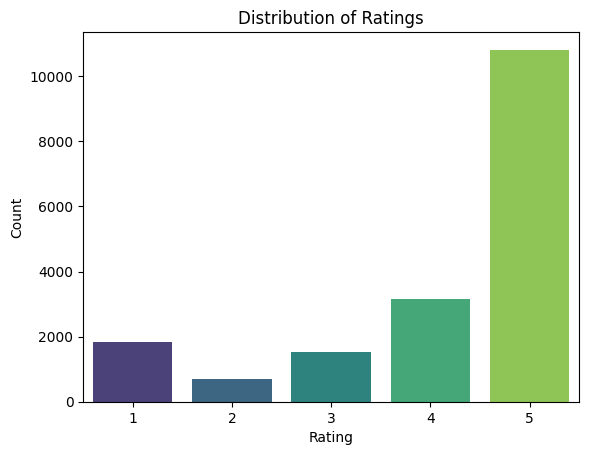

In [20]:
sns.countplot(x='rating', data=df_clean_v2, palette='viridis')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


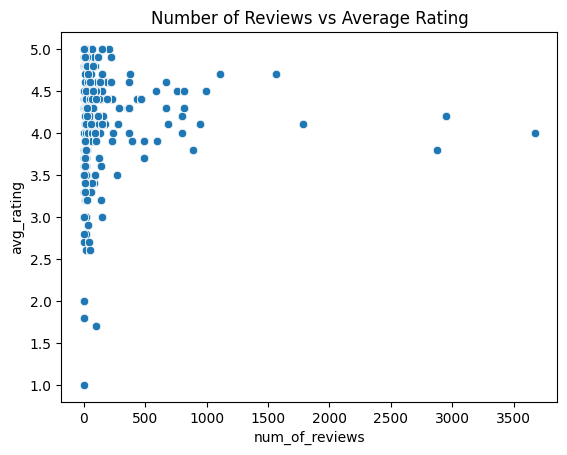

In [21]:
sns.scatterplot(x='num_of_reviews', y='avg_rating', data=df_clean_v2)
plt.title('Number of Reviews vs Average Rating')
plt.show()

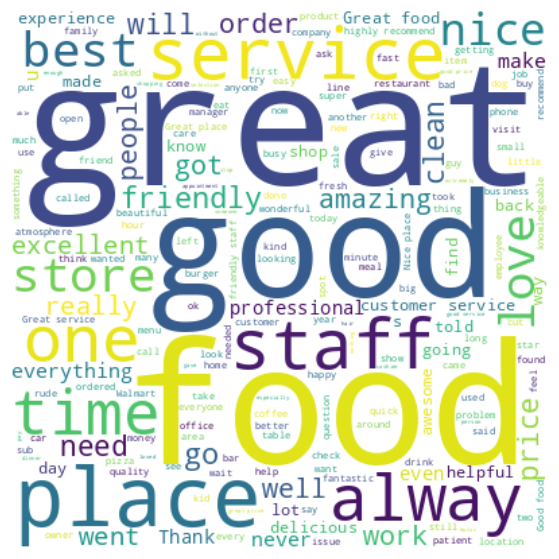

In [22]:
# Word cloud to review text
# Reveals common words; spam and ads often contain promotional keywords or repeated phrases

text = ' '.join(df_clean_v2['text'].dropna())
wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 📊 Insights from Visualizations

Based on our initial visualizations:  

- **Rating Distribution** – Most reviews are **positive**, skewed toward **5-star ratings**, suggesting generally good experiences or a tendency for users to leave positive feedback. Lower ratings exist but are less frequent.  

- **Number of Reviews vs Average Rating** – Businesses with few reviews show **wide variability**, while high-volume businesses cluster around **4–5 stars**, indicating consistent service quality or strong reputation.  

- **Word Cloud of Review Text** – Common terms like `"place"`, `"good"`, `"love"`, `"service"`, `"staff"`, and `"customer"` dominate, reflecting a focus on **experience, service, and food quality**. Words like `"best"` and `"always"` indicate positive sentiment, with minimal spam or promotional content.  

These observations suggest that **detecting policy violations is non-trivial**, but with **careful feature engineering**, we can create additional flags to identify **potential spam, advertisements, or irrelevant reviews**.


## ✨ **Feature Engineering**

Feature engineering is where the real signal comes from in this dataset.  
Google has already applied filters to remove obvious spam, advertisements, and outliers, and **user metadata is limited**, making this task more challenging.  

However, we can extract meaningful features from the **review content and metadata** to help the model identify subtle patterns of quality, relevance, and potential policy violations.  

We will create the following features:  

- **Review Length** – Number of words or characters in the review  
- **Number of Exclamation Points** – Captures emotional intensity or exaggeration  
- **Capital Word Ratio** – Fraction of words in uppercase, indicating emphasis or shouting  
- **Polarity of Review** – Sentiment score (positive, negative, neutral)  
- **Subjectivity of Review** – Measures whether the review is opinion-based or factual  
- **Presence of URL** – Detects potential spam or promotional content  
- **Reading Level Complexity** – Flesch-Kincaid score for linguistic complexity  
- **Age of Review** – Time since the review was posted, highlighting recency effects  
- **Cosine Similarity** – Between review text and the location’s category+description to assess relevancy  
- **User Rating Deviation** – Difference from the business’ average rating, indicating unusually extreme reviews  
- **Profanity Check** – Flags inappropriate or offensive language  

These engineered features provide **rich signals** that go beyond raw text and ratings, helping the model **distinguish genuine reviews from low-quality or policy-violating content**.


In [23]:
# Review length is important because extremely short or unusually long reviews often signal spam, ads, or low-quality content,
# while moderately detailed reviews are more likely relevant.

# I will be using word_tokenize from the nltk library as it is more accurate
def word_count(text):
    words = word_tokenize(text)
    return len(words)

df_clean_v2['review_length'] = df_clean_v2['text'].apply(word_count)

/tmp/ipython-input-3315116761.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_v2['review_length'] = df_clean_v2['text'].apply(word_count)


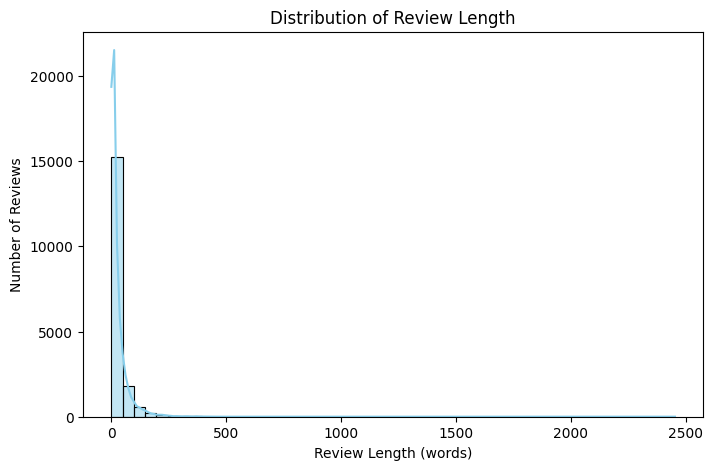

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(df_clean_v2['review_length'], bins=50, kde=True, color='skyblue')
plt.xlabel("Review Length (words)")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Length")
plt.show()

Interestingly, most reviews are **between 0–50 words**, with a sharp decline for longer reviews. This suggests that **short-form reviews dominate**, while longer, more detailed feedback is relatively rare.


In [26]:
# Let's define some reusable functions for the notebook.
# These functions will generate a `cleaned_review` column, which is essential for model training,
# as NLP models like DistilBERT perform better on text that has been thoroughly cleaned using NLTK.

# Take note just do this once,Takes very long to run
def clean_text(content):

    # Remove HTML tags (handles full tags like <br> and broken tags like < br >)
    content = re.sub(r'<.*?>', ' ', content)

    # Lowercase everything
    content = content.lower()

    # Remove numbers
    content = re.sub(r'\d+', '', content)

    # Remove all punctuation (including weird symbols)
    content = re.sub(r'[^\w\s]', ' ', content)

    # Remove extra spaces (caused by all that cleaning)
    content = re.sub(r'\s+', ' ', content).strip()

    # Load stopwords and add custom stopwords like 'br'
    stop_words = set(stopwords.words('english'))
    custom_stop_words = ['br']  # <br> becomes br after HTML removal
    stop_words.update(custom_stop_words)

    # Tokenize and remove stopwords
    words = word_tokenize(content)
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]

    # Lemmatize (bring words to root form)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, tag in pos_tag(filtered_words):
        pos = tag[0].lower() if tag[0].lower() in ['a', 'n', 'v', 'r'] else 'n'
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))

    # Join back into one string
    content = ' '.join(lemmatized_words)

    return content

df_clean_v2['cleaned_review'] = df_clean_v2["text"].apply(clean_text)

/tmp/ipython-input-2605632844.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_v2['cleaned_review'] = df_clean_v2["text"].apply(clean_text)


Just to take note to find the cosine similarity, i used the `all-MiniLM-L6-v2 ` embedding models from

*    [SentenceTransformers](https://sbert.net/)


In [29]:
# Count the number of exclamation point
def exclamation_count(text):
    return text.count('!')

def capital_word_count(text):
    words = word_tokenize(text)
    capital_words = [word for word in words if word.isupper() and len(word) > 1]  # Exclude single-char words
    return len(capital_words)

# Compute the readability score using the Flesch-Kincaid formula
# Grade Level = 0.39 × (total words/total sentences) + 11.8 × (total syllables/total words) - 15.59
def readability_score(text):
    r = Readability(text) # Initialize Readability analysis
    try:
        return r.flesch_kincaid().score
    except:
        return 0  # Handle cases where the text is too short or causes an error

# Prescence of URL
def url_check(text):
    url_pattern = re.compile(
      r'((http|https)://[^\s]+|www\.[^\s]+)',
      re.IGNORECASE
    )
    return 1 if url_pattern.search(text) else 0

# Check the age of the review posted
# The dataset cut of was up to September 2021,thus this will serve as the current date

def age_of_review(timestamp):
    ref_dt_ms = int(datetime(2021, 9, 30, 0, 0, 0).timestamp() * 1000)
    diff_ms = ref_dt_ms - timestamp
    diff_days = diff_ms / (1000 * 60 * 60 * 24)
    return diff_days


# Deviation between user rating and business avg rating
def rating_deviation(user_rating, business_avg_rating):
    return abs(user_rating - business_avg_rating)

# Check if the text contains profanity (simple check)
def profanity_check(text):
    return predict([text])[0]


# Polarity and Subjectivity of review text will be done using the textblob library
# Polarity ranges from -1 (negative) to 1 (positive), with 0 being neutral
def get_polarity(text):
    return TextBlob(text).sentiment.polarity  # Extract sentiment polarity using TextBlob

# Function to calculate the subjectivity of a given text
# Subjectivity ranges from 0 (objective) to 1 (subjective)
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity  # Extract sentiment subjectivity using TextBlob

# Apply functions row-wise
df_clean_v2["exclamation_count"] = df_clean_v2["text"].apply(exclamation_count)
df_clean_v2["capital_word_count"] = df_clean_v2["text"].apply(capital_word_count)
df_clean_v2["readability_score"] = df_clean_v2["text"].apply(readability_score)
df_clean_v2["url_present"] = df_clean_v2["text"].apply(url_check)
df_clean_v2["age_of_review"] = df_clean_v2["time"].apply(age_of_review)
df_clean_v2["rating_deviation"] = (df_clean_v2["rating"] - df_clean_v2["avg_rating"]).abs()
df_clean_v2["profanity_flag"] = df_clean_v2["text"].apply(profanity_check)
df_clean_v2['polarity'] = df_clean_v2['cleaned_review'].apply(get_polarity)
df_clean_v2['subjectivity'] = df_clean_v2['cleaned_review'].apply(get_subjectivity)

# Convert category to string (handling lists/arrays)
df_clean_v2["category_str"] = df_clean_v2["category"].apply(
    lambda x: " ".join(map(str, x)) if isinstance(x, (list, pd.Series, np.ndarray)) else (x if isinstance(x, str) else "")
)

# Fill description NA with ""
df_clean_v2["description"] = df_clean_v2["description"].fillna("")

# Vectorized string concatenation
df_clean_v2["business_text"] = df_clean_v2["description"] + " " + df_clean_v2["category_str"]
df_clean_v2["business_text"] = df_clean_v2["business_text"].apply(clean_text)

# Compute sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
review_embeddings = model.encode(df_clean_v2["cleaned_review"].tolist())
business_embeddings = model.encode(df_clean_v2["business_text"].tolist())

# Compute cosine similarity row-wise
df_clean_v2["sim_btw_review_business"] = [util.cos_sim(review_embeddings[i], business_embeddings[i]).item() for i in range(len(df_clean_v2))]

/tmp/ipython-input-4229788394.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_v2["exclamation_count"] = df_clean_v2["text"].apply(exclamation_count)
/tmp/ipython-input-4229788394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_v2["capital_word_count"] = df_clean_v2["text"].apply(capital_word_count)
/tmp/ipython-input-4229788394.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/tmp/ipython-input-4229788394.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_v2["sim_btw_review_business"] = [util.cos_sim(review_embeddings[i], business_embeddings[i]).item() for i in range(len(df_clean_v2))]


In [30]:
# Additional columns to remove since it is no longer useful
cols_to_drop = [
    'name',
    'time',
    'business_name',
    'category',
    'business_text',
    'price',
    'description',
    'category_str'
]

df_clean_v3 = df_clean_v2.drop(columns=cols_to_drop)
df_clean_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18033 entries, 7 to 32233
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  18033 non-null  object 
 1   rating                   18033 non-null  Int64  
 2   text                     18033 non-null  object 
 3   avg_rating               18033 non-null  float64
 4   num_of_reviews           18033 non-null  int64  
 5   review_length            18033 non-null  int64  
 6   cleaned_review           18033 non-null  object 
 7   exclamation_count        18033 non-null  int64  
 8   capital_word_count       18033 non-null  int64  
 9   readability_score        18033 non-null  float64
 10  url_present              18033 non-null  int64  
 11  age_of_review            18033 non-null  float64
 12  rating_deviation         18033 non-null  Float64
 13  profanity_flag           18033 non-null  int64  
 14  polarity                 18

In [31]:
df_clean_v3.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,18033,16895,106541235955558877709,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,18033.0,<NA>,<NA>,<NA>,4.1332,1.317247,1.0,4.0,5.0,5.0,5.0
text,18033,16431,Good,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating,18033.0,NaN,NaN,NaN,4.22166,0.441665,1.0,4.0,4.2,4.5,5.0
num_of_reviews,18033.0,NaN,NaN,NaN,936.915932,1072.666334,1.0,128.0,585.0,1108.0,3674.0
review_length,18033.0,NaN,NaN,NaN,28.491044,48.447867,1.0,6.0,13.0,33.0,2454.0
cleaned_review,18033,15681,good,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exclamation_count,18033.0,NaN,NaN,NaN,0.597127,18.290812,0.0,0.0,0.0,0.0,2450.0
capital_word_count,18033.0,NaN,NaN,NaN,0.263683,2.678076,0.0,0.0,0.0,0.0,200.0
readability_score,18033.0,NaN,NaN,NaN,0.381513,2.349301,0.0,0.0,0.0,0.0,106.543978


In [33]:
# I have created the features as a possible but since in this subset exclamation_count,capital_word_count,url_present,profanity_flag exist so little i have no choice to remove it
# Further more the readebility score is also quite nonexistant and irrelevant
cols_to_drop = [
    'exclamation_count',
    'capital_word_count',
    'url_present',
    'profanity_flag',
    'readability_score'
]

df_clean_v3 = df_clean_v3.drop(columns=cols_to_drop)
df_clean_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18033 entries, 7 to 32233
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  18033 non-null  object 
 1   rating                   18033 non-null  Int64  
 2   text                     18033 non-null  object 
 3   avg_rating               18033 non-null  float64
 4   num_of_reviews           18033 non-null  int64  
 5   review_length            18033 non-null  int64  
 6   cleaned_review           18033 non-null  object 
 7   age_of_review            18033 non-null  float64
 8   rating_deviation         18033 non-null  Float64
 9   polarity                 18033 non-null  float64
 10  subjectivity             18033 non-null  float64
 11  sim_btw_review_business  18033 non-null  float64
dtypes: Float64(1), Int64(1), float64(5), int64(2), object(3)
memory usage: 1.8+ MB


It might be weird that i have created then deleted rows, but there are part of experiments cater to the dataset

The next thing i created was a SUSPICOUS_SCORE Indicator which by some rule based system will assigne every review a certain SUSPICOUS_SCORE rating, the default values are below butif you want to play around

In [34]:
def calculate_suspicion_score(df):
    # --- Thresholds ---
    TH = {
        'VERY_SHORT_LEN': 10,
        'VERY_LONG_LEN': 500,
        'LONG_LEN': 200,
        'SIM_VERY_LOW': 0.15,
        'SIM_LOW': 0.30,
        'POL_NEG_T': -0.5,
        'NEUTRAL_T': 0.1,
        'SUBJECTIVITY_HIGH': 0.6,
        'RATING_DEV_T': 2.0,
    }

    # --- Weights ---
    WEIGHTS = {
        'sim_very_low': 4.0,
        'sim_low': 2.0,
        'polarity_neg_strong': 3.0,
        'polarity_neutral_small': 2.0,
        'subjectivity_high': 2.0,
        'rating_deviation_high': 2.0,
        'very_short_len': 2.0,
        'very_long_len': 1.0,
        'long_len': 1.5,
    }

    # --- Build indicators ---
    ind = pd.DataFrame(index=df.index)
    ind['sim_very_low'] = (df['sim_btw_review_business'] < TH['SIM_VERY_LOW']).astype(float)
    ind['sim_low'] = (df['sim_btw_review_business'] < TH['SIM_LOW']).astype(float)

    ind['polarity_neg_strong'] = (df['polarity'] < TH['POL_NEG_T']).astype(float)
    ind['polarity_neutral_small'] = (df['polarity'].abs() < TH['NEUTRAL_T']).astype(float)
    ind['subjectivity_high'] = (df['subjectivity'] > TH['SUBJECTIVITY_HIGH']).astype(float)

    ind['rating_deviation_high'] = (df['rating_deviation'].abs() > TH['RATING_DEV_T']).astype(float)

    ind['very_short_len'] = (df['review_length'] < TH['VERY_SHORT_LEN']).astype(float)
    ind['very_long_len'] = (df['review_length'] > TH['VERY_LONG_LEN']).astype(float)
    ind['long_len'] = (df['review_length'] > TH['LONG_LEN']).astype(float)

    # --- Raw weighted sum ---
    raw_score = (
        ind['sim_very_low'] * WEIGHTS['sim_very_low'] +
        ind['sim_low'] * WEIGHTS['sim_low'] +
        ind['polarity_neg_strong'] * WEIGHTS['polarity_neg_strong'] +
        ind['polarity_neutral_small'] * WEIGHTS['polarity_neutral_small'] +
        ind['subjectivity_high'] * WEIGHTS['subjectivity_high'] +
        ind['rating_deviation_high'] * WEIGHTS['rating_deviation_high'] +
        ind['very_short_len'] * WEIGHTS['very_short_len'] +
        ind['very_long_len'] * WEIGHTS['very_long_len'] +
        ind['long_len'] * WEIGHTS['long_len']
    )

    # --- Normalize 0..100 ---
    max_possible = sum(WEIGHTS.values())
    df['suspicion_score'] = (raw_score / max_possible * 100).clip(0, 100).round(1)

    return df
df_clean_v3 = calculate_suspicion_score(df_clean_v3)

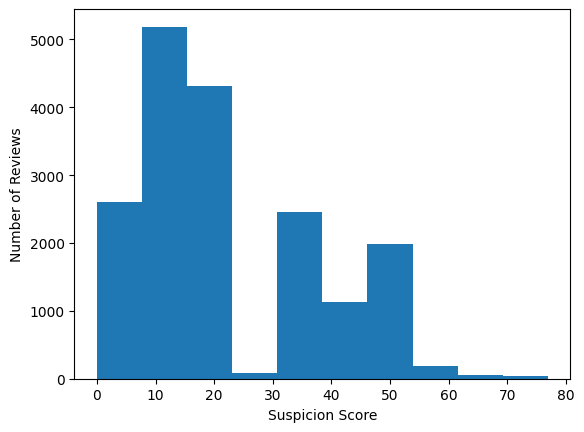

In [35]:
plt.hist(df_clean_v3['suspicion_score'], bins=10)
plt.xlabel("Suspicion Score")
plt.ylabel("Number of Reviews")
plt.show()


From the graph, it is evident that the **majority of reviews have a suspicion score between 0–20**, indicating generally low risk of policy violation.  
A smaller cluster falls in the **30–50 range**, representing moderately suspicious reviews, while only a few reviews score **above 60**, highlighting potentially high-risk content that may warrant closer inspection.


In [ ]:
# We will use the suspicion_score to create more high quality dataset for our LLM to train on

# High-suspicion: keep all
high_susp = df_clean_v3[df_clean_v3['suspicion_score'] >= 50]

# Medium-suspicion: keep all or most
medium_susp = df_clean_v3[(df_clean_v3['suspicion_score'] >= 30) & (df_clean_v3['suspicion_score'] < 50)]

# Lets keep a sample of our low-suspicion data as well ard 15% of it
# Low-suspicion: sample a small fraction
low_susp_sample = df_clean_v3[df_clean_v3['suspicion_score'] < 30].sample(frac=0.15, random_state=42)

# Combine
llm_dataset = pd.concat([high_susp, medium_susp, low_susp_sample]).reset_index(drop=True)

In [ ]:
llm_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7675.0,3.918567,1.455271,1.0,3.0,5.0,5.0,5.0
avg_rating,7675.0,4.155166,0.42933,1.0,3.9,4.2,4.4,5.0
num_of_reviews,7675.0,1111.886515,1171.014461,1.0,146.0,668.0,1783.0,3674.0
review_length,7675.0,19.513485,50.508216,1.0,3.0,7.0,18.0,2454.0
age_of_review,7675.0,970.122276,546.353751,46.853238,591.975935,921.037694,1283.265747,5670.0
rating_deviation,7675.0,1.047987,0.919316,0.0,0.4,0.8,1.2,3.9
polarity,7675.0,0.317732,0.41776,-1.0,0.0,0.366667,0.7,1.0
subjectivity,7675.0,0.54725,0.306874,0.0,0.4,0.6,0.75,1.0
sim_btw_review_business,7675.0,0.199747,0.145593,-0.112738,0.092969,0.167608,0.280156,0.843801
suspicion_score,7675.0,34.299336,15.818569,0.0,30.8,30.8,51.3,76.9


In [ ]:
llm_dataset.shape

(7675, 13)

Wow! Our dataset has been reduced from **33K reviews to 7K**, but this was a **necessary step**.  
By focusing on a smaller, **high-quality, and diverse subset**, we ensure that our **pseudo-labeling with the LLM** is accurate and meaningful, setting a strong foundation for model training.


## 👾 **Pseudo LLM Labeling**

To generate high-quality pseudo labels for our dataset, we leveraged **GPT-OSS-20B**, a state-of-the-art open-source language model released in **Aug 2025**. This model excels at **contextual understanding, summarization, and coherent text generation**, making it perfect for tasks like **review classification and policy violation detection**.  

**Why GPT-OSS-20B is ideal for pseudo labeling:**  

- **Deep contextual comprehension** – Detects subtle signals in review text that indicate spam, irrelevance, or promotional content.  
- **Context-aware labeling** – Produces accurate pseudo labels based on content and sentiment, even with minimal explicit annotations.  
- **High efficiency** – Significantly reduces manual labeling effort, allowing rapid scaling across thousands of reviews.  
- **Consistency & reliability** – Ensures uniform labeling criteria, reducing human bias and variability in the dataset.  

By using GPT-OSS-20B, we create a **robust, high-quality labeled dataset**, forming a solid foundation for training supervised machine learning models.  

For this, I utilized **Groq Cloud**. Simply visit [Groq](https://console.groq.com/docs/overview), register, create an API key, and securely store it in Colab’s secrets.  

Even with **7K reviews**, labeling on a developer account cost only **~$1.50 USD**, highlighting Groq Cloud as a **fast, reliable, and cost-effective solution** for large-scale pseudo labeling.  

Finally, the **key to achieving high-quality results with LLMs** is crafting a **precise and well-structured prompt**, which guides the model to consistently classify reviews with accuracy and nuance.


In [ ]:
# Save Locally
llm_dataset.to_parquet(f"{DIR}/dataset/llm_dataset.parquet")

In [ ]:
llm_dataset.iloc[100]['text']

'They didnt put the thing I wanted on hold even though they said they did'

In [ ]:
llm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  7675 non-null   object 
 1   rating                   7675 non-null   Int64  
 2   text                     7675 non-null   object 
 3   avg_rating               7675 non-null   float64
 4   num_of_reviews           7675 non-null   int64  
 5   review_length            7675 non-null   int64  
 6   cleaned_review           7675 non-null   object 
 7   age_of_review            7675 non-null   float64
 8   rating_deviation         7675 non-null   Float64
 9   polarity                 7675 non-null   float64
 10  subjectivity             7675 non-null   float64
 11  sim_btw_review_business  7675 non-null   float64
 12  suspicion_score          7675 non-null   float64
dtypes: Float64(1), Int64(1), float64(6), int64(2), object(3)
memory usage: 794.6+ 

The following prompt will ensure that the LLM will return a JSON object that contains the labels as well as a confidence score which we can use for filtering later on

In [ ]:
# This is the prompt that i have used but definitely it can be improved but for this case i was balancing the token count as well
def prompt_template(reviewed_row):
    GENERAL_PROMPT = f"""
        You are a professional review moderator. Your task is to classify the following review into **exactly one** of the five predefined categories based on content, context, and behavioral signals.

        **Classification Labels (in descending priority):**
        1. **SPAM** – Unsolicited, bot-generated, gibberish, repetitive, or clearly fake content with no meaningful information.
        2. **ADVERTISEMENT** – Promotional in nature, urging others to buy, visit, or use a competing or unrelated product/service.
        3. **RANT_WITHOUT_VISIT** – Highly negative, emotional, or aggressive tone, but lacking any evidence (e.g., specifics, usage details) that the reviewer actually experienced the business.
        4. **IRRELEVANT_CONTENT** – Off-topic, unrelated to the business (e.g., political rant, random story), or discussing a different location/product.
        5. **NONE** – A legitimate, experience-based review reflecting a genuine user opinion (positive or negative).

        > ⚠️ **Label priority is strict**: If a review qualifies for multiple labels, assign the one with **highest priority** (SPAM > ADVERTISEMENT > RANT_WITHOUT_VISIT > IRRELEVANT_CONTENT > NONE).

        ---

        **Review Analysis Context:**

        - **Text:** {reviewed_row['text']}
        - **Rating:** {reviewed_row['rating']}/5 *(Business Average: {reviewed_row['avg_rating']})*
          → Indicates sentiment deviation from typical customer experience.
        - **Review Length:** {reviewed_row['review_length']} words
          → Extremely short (<10) or unusually long (>500) may suggest low effort, spam, or ranting.
        - **Total Business Reviews:** {reviewed_row['num_of_reviews']}
          → Low count increases sensitivity to outliers; high count makes extreme reviews less suspicious if isolated.
        - **Sentiment:** Polarity = {reviewed_row['polarity']:.2f} *(−1 = very negative, +1 = very positive)*, Subjectivity = {reviewed_row['subjectivity']:.2f} *(0 = factual, 1 = emotional/opinionated)*
        - **Review Age:** {reviewed_row['age_of_review']:.0f} days
          → Older reviews may reflect outdated experiences but are not inherently suspicious.
        - **Similarity to Business:** {reviewed_row['sim_btw_review_business']:.3f}
          → Low similarity suggests off-topic or generic content; high similarity aligns with typical reviews.
        - **Rating Deviation:** {reviewed_row['rating_deviation']:.2f}
          → Large negative deviation (e.g., 1-star on 4.8 avg) increases scrutiny for ranting or inauthenticity.
        - **Suspicion Score:** {reviewed_row['suspicion_score']:.2f}
          → Aggregated risk score from multiple signals (spam, emotion, deviation). Higher = more suspicious.

        ---

        **Instructions:**
        - Analyze all signals holistically, but prioritize **content intent** and **evidence of real experience**.
        - Favor **specificity, coherence, and relevance** when considering "NONE".
        - Respond **only** in the following JSON format:

        {{
          "label": "SPAM | ADVERTISEMENT | RANT_WITHOUT_VISIT | IRRELEVANT_CONTENT | NONE",
          "confidence_level": 0.0–1.0
        }}

        """

    return GENERAL_PROMPT

In [ ]:
# Create a API_KEY in colab secrets and place it below
api_key = os.environ.get("GROQ_API_KEY")


def llm_call(text):
    prompt = prompt_template(text)
    user_message = {"role": "user", "content": prompt}

    response = client.chat.completions.create(
        model="openai/gpt-oss-20b",
        messages=[user_message],
        max_completion_tokens=8192,
        temperature=0.2,
        response_format={"type": "json_object"},
        seed=42
    )

    result = json.loads(response.choices[0].message.content)
    return result  # return dict directly

In [ ]:
pred1 = {}
for idx, row in tqdm(llm_dataset.iterrows(), total=len(llm_dataset), desc="Processing reviews"):
    result_dict = llm_call(row)
    pred1[idx] = result_dict

Processing reviews: 100%|██████████| 7675/7675 [1:04:53<00:00,  1.97it/s]


The total process took around a hour to complete

In [ ]:
pred

{0: {'label': 'RANT_WITHOUT_VISIT', 'confidence_level': 0.9},
 1: {'label': 'SPAM', 'confidence_level': 0.95},
 2: {'label': 'NONE', 'confidence_level': 0.85},
 3: {'label': 'NONE', 'confidence_level': 0.75},
 4: {'label': 'SPAM', 'confidence_level': 0.9},
 5: {'label': 'RANT_WITHOUT_VISIT', 'confidence_level': 0.85},
 6: {'label': 'SPAM', 'confidence_level': 0.85},
 7: {'label': 'NONE', 'confidence_level': 0.4},
 8: {'label': 'SPAM', 'confidence_level': 0.95},
 9: {'label': 'NONE', 'confidence_level': 0.78}}

In [ ]:
# Save to dataframe for combination
pred_df = pd.DataFrame.from_dict(pred1, orient="index")
final_dataset = llm_dataset.join(pred_df)

In [ ]:
final_dataset['label'].value_counts()

,count
label,
NONE,4372
SPAM,2461
RANT_WITHOUT_VISIT,648
IRRELEVANT_CONTENT,143
ADVERTISEMENT,51


This distribution is as expected, as the majority of reviews (**4,372**) are **normal**, reflecting the fact that most user review are already clean and genuine. The smaller counts of **spam (2,461)**, **rant without visit (648)**, **irrelevant content (143)**, and **advertisement (51)** indicate that policy-violating reviews exist but are relatively rare, which aligns with typical online review behavior and highlights the **challenge of detecting subtle low-quality content**.


In [ ]:
final_dataset.to_parquet(f"{DIR}/dataset/final_dataset.parquet")

## 🧠 **Model Building**

For this **classification task**, my first instinct was to use **BERT (Bidirectional Encoder Representations from Transformers)** due to its ability to capture **context and nuanced meaning** in text. BERT is highly effective for detecting subtle patterns in reviews, such as spam, irrelevance, or policy violations.  

---
![BERT Architecture](https://towardsdatascience.com/wp-content/uploads/2024/05/1Qww2aaIdqrWVeNmo3AS0ZQ.png)
(*Image from Towards Data Science*)

While BERT is a state-of-the-art model for text classification, I opted for **DistilBERT**, a **lightweight, faster alternative**, which offers several advantages:  

- **Faster training and inference** – Smaller model size leads to reduced computational costs and quicker experimentation.  
- **Reduced memory footprint** – Suitable for limited resources like Google Colab, without compromising much on performance.  
- **High performance** – Retains ~97% of BERT’s accuracy while being significantly more efficient.  
- **Easy integration** – Compatible with standard transformers pipelines, making fine-tuning and deployment straightforward.  
- **Ideal for iterative experiments** – Enables rapid prototyping, testing multiple configurations, and tuning hyperparameters efficiently.  

These benefits make **DistilBERT a practical choice** for hackathon-scale projects where **speed, efficiency, and strong performance** are all critical.


---

For this problem, I implemented **two versions of DistilBERT** to evaluate performance and leverage additional features:  

- **Base Model** – Uses only the **review text** as input for classification.  
- **Custom Model** – Incorporates **review text + engineered features** along with **dropout layers** to improve generalization.  

Given the **class imbalance** in our dataset, I also developed a **custom Trainer** that adjusts **class weights**, ensuring that minority classes receive sufficient attention during training.  

All of this was implemented using the **Hugging Face Transformers** and **Datasets** libraries, enabling seamless fine-tuning and model evaluation.




In [35]:
final_dataset = pd.read_parquet(f"{DIR}/dataset/final_dataset.parquet")

In [36]:
print(f"Shape of dataset:{final_dataset.shape}")

Shape of dataset:(7675, 15)


Let us make use of the confidence level returned by the LLM and filter to keep those above 0.7

In [37]:
print(f"Shape of dataset:{final_dataset.shape}")

# Let us drop confidence_level < 0.7 to create a even more high quality data

final_datasetv2 = final_dataset[final_dataset['confidence_level'] >= 0.7]
print(f"Shape of dataset:{final_datasetv2.shape}")
print(f"Total Dropped: {final_dataset.shape[0] - final_datasetv2.shape[0]}")

Shape of dataset:(7675, 15)
Shape of dataset:(7188, 15)
Total Dropped: 487


In [38]:
final_datasetv2['label'].value_counts()

,count
label,
NONE,3909
SPAM,2447
RANT_WITHOUT_VISIT,642
IRRELEVANT_CONTENT,139
ADVERTISEMENT,51


### **Base DistilBERT Model**

In [ ]:
# Let us convert our dataframe to a huggingface dataset so that it will be easier to perform our operations
dataset = Dataset.from_pandas(final_datasetv2)

In [ ]:
# Initiate the DistilBERT Tokenizer i will use the distilbert/distilbert-base-uncased model which is great for fine tuning
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased"
)

# Lets see what the tokenizer does sample text
sample_text = "I absolutely loved this restraunt"
tokens = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128)

print(tokens)

{'input_ids': [101, 1045, 7078, 3866, 2023, 2717, 2527, 16671, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
# Initiate the model that we will be using
model_name = "distilbert/distilbert-base-uncased"
label_names = [
    "NONE",
    "SPAM",
    "RANT_WITHOUT_VISIT",
    "IRRELEVANT_CONTENT",
    "ADVERTISEMENT"
]
num_labels = len(label_names)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels, # Since there is 5 labels we have to predict
    device_map="auto", # Default uses GPU
    id2label={i: label for i, label in enumerate(label_names)},
    label2id={label: i for i, label in enumerate(label_names)}
)


print(model.config)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NONE",
    "1": "SPAM",
    "2": "RANT_WITHOUT_VISIT",
    "3": "IRRELEVANT_CONTENT",
    "4": "ADVERTISEMENT"
  },
  "initializer_range": 0.02,
  "label2id": {
    "ADVERTISEMENT": 4,
    "IRRELEVANT_CONTENT": 3,
    "NONE": 0,
    "RANT_WITHOUT_VISIT": 2,
    "SPAM": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.55.4",
  "vocab_size": 30522
}



The zero represents padding to reach max_length, the parameter of max length is important as the right max_length will affect model performance

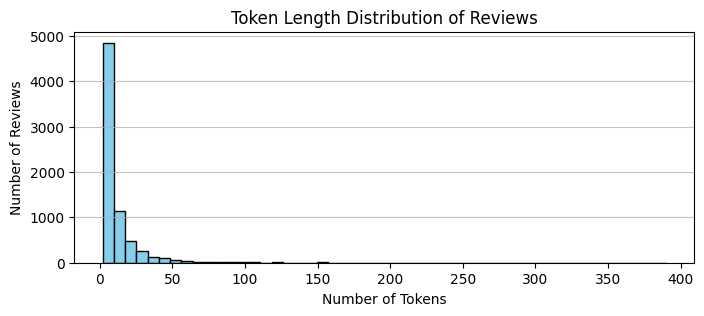

In [ ]:
text_token_length = [len(tokenizer.encode(text)) for text in dataset['cleaned_review']]

plt.figure(figsize=(8,3))
plt.hist(text_token_length, bins=50, color='skyblue', edgecolor='black')
plt.title("Token Length Distribution of Reviews")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', alpha=0.75)
plt.show()

Most tokens fall from 50-100 with some outliers in the range of 150-200, Just to be cautious i will set the max length as 200 this is for the Custom model as well

In [ ]:
# Let us split the dataset innto train and test with 80% train 20% test

# First we need to convert the label column to ClassLabels

dataset = dataset.cast_column("label", ClassLabel(names=label_names))
print(f"Label names: {dataset.features["label"].names}")

split_dataset = dataset.train_test_split(test_size=0.2, seed=42,stratify_by_column="label")

# Access the splits
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

Casting the dataset:   0%|          | 0/7188 [00:00<?, ? examples/s]

Label names: ['NONE', 'SPAM', 'RANT_WITHOUT_VISIT', 'IRRELEVANT_CONTENT', 'ADVERTISEMENT']


In [ ]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['user_id', 'rating', 'text', 'avg_rating', 'num_of_reviews', 'review_length', 'cleaned_review', 'age_of_review', 'rating_deviation', 'polarity', 'subjectivity', 'sim_btw_review_business', 'suspicion_score', 'label', 'confidence_level', '__index_level_0__'],
        num_rows: 5750
    })
    test: Dataset({
        features: ['user_id', 'rating', 'text', 'avg_rating', 'num_of_reviews', 'review_length', 'cleaned_review', 'age_of_review', 'rating_deviation', 'polarity', 'subjectivity', 'sim_btw_review_business', 'suspicion_score', 'label', 'confidence_level', '__index_level_0__'],
        num_rows: 1438
    })
})

In [ ]:
# Account for class imbalances
labels = split_dataset["train"]["label"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
print("Label names:", dataset.features["label"].names)
print("Class weights:", class_weights)

Label names: ['NONE', 'SPAM', 'RANT_WITHOUT_VISIT', 'IRRELEVANT_CONTENT', 'ADVERTISEMENT']
Class weights: tensor([ 0.3678,  0.5876,  2.2374, 10.3604, 28.0488], device='cuda:0')


More weight will be given on ADVERTISMENT as it appears very little in the dataset

In [ ]:
# Create a tokenizer function for our dataset

def tokenize_function(row):
  return tokenizer(row['cleaned_review'],padding="max_length", truncation=True, max_length=200)

tokenized_dataset = split_dataset.map(tokenize_function, batched=True)

print(tokenized_dataset["train"][0])

Map:   0%|          | 0/5750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

{'user_id': '110933742440509369537', 'rating': 2, 'text': 'Slow service', 'avg_rating': 3.5, 'num_of_reviews': 268, 'review_length': 2, 'cleaned_review': 'slow service', 'age_of_review': 1522.1500489699074, 'rating_deviation': 1.5, 'polarity': -0.30000000000000004, 'subjectivity': 0.39999999999999997, 'sim_btw_review_business': 0.16572952270507812, 'suspicion_score': 20.5, 'label': 2, 'confidence_level': 0.82, '__index_level_0__': 6256, 'input_ids': [101, 4030, 2326, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
class_weights

tensor([ 0.3678,  0.5876,  2.2374, 10.3604, 28.0488], device='cuda:0')

In [ ]:
# To use our balanced class labels we have to subclass Trainer and change the compute loss function
class CustomTrainer(Trainer):

  def __init__(self,*args,**kwargs):
    self.class_weights = kwargs.pop("class_weights")
    super().__init__(*args,**kwargs)


  def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get('logits')

    loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

    return (loss, outputs) if return_outputs else loss

Below is the code to train our model, I will explain the metrics that i have chosen to evaluate the performance of the model



*   Accuracy – Measures the overall proportion of correct predictions, giving a general sense of performance.

- Precision (weighted) – Reflects how many predicted positives are actually correct, accounting for the imbalance so that majority classes don’t dominate.

- Recall (weighted) – Indicates how many actual positives are correctly identified, ensuring minority classes receive attention.

- F1 Score (weighted & macro) – Balances precision and recall; weighted F1 accounts for class frequencies, while macro F1 treats all classes equally, highlighting performance on underrepresented classes.

- Cohen’s Kappa – Measures agreement between predictions and true labels while correcting for chance agreement, providing a robust metric for imbalanced data.

- Per-class F1 scores – Evaluates the model’s ability to predict each individual class, crucial for understanding performance on minority classes like SPAM, RANT, IRRELEVANT, and ADVERTISEMENT.


However it must be noted that relying on accuracy alone might be misleading  For instance, if the majority of reviews are labeled as “NONE,” a model could achieve high accuracy simply by predicting this class for all inputs, while **failing to identify minority classes** like SPAM, RANT, IRRELEVANT, or ADVERTISEMENT.  

Thus F1_Score is more important in this case especially **F1 Macro**  because it treats all classes equally, making it ideal for our **imbalanced dataset**.  F1 Macro ensures that the model’s performance on **minority classes** like SPAM, RANT, IRRELEVANT, and ADVERTISEMENT is properly captured. This provides a **more reliable and meaningful measure of model effectiveness** than accuracy alone.



In [ ]:
# Define a data collector for efficient training
data_collector = DataCollatorWithPadding(tokenizer=tokenizer)

# Define custom compute metrics
def compute_metrics(pred):
  logits, labels = pred
  predictions = np.argmax(logits, axis=-1)

   # Per-class F1
  f1_per_class = f1_score(labels, predictions, average=None)
  class_names = ["NONE", "SPAM", "RANT", "IRRELEVANT", "ADVERTISEMENT"]
  per_class_metrics = {f"f1_{name}": f1_per_class[i] for i, name in enumerate(class_names)}

  return {
      'accuracy': accuracy_score(labels, predictions),
      'precision': precision_score(labels, predictions, average='weighted'),
      'recall': recall_score(labels, predictions, average='weighted'),
      'f1_weighted': f1_score(labels, predictions, average='weighted'),
      'kappa': cohen_kappa_score(labels, predictions),
      'f1_macro': f1_score(labels, predictions, average='macro'),
      **per_class_metrics
  }

MODEL_DIR = f"{DIR}/first_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Define training arguments
training_args = TrainingArguments(
      output_dir=f"{MODEL_DIR}/results",  # Directory for saving model checkpoints
      eval_strategy="epoch",              # Evaluate at the end of each epoch
      learning_rate=1e-5,                 # Start with a small learning rate
      per_device_train_batch_size=16,     # Batch size per GPU
      per_device_eval_batch_size=16,
      num_train_epochs=5,                 # Number of epochs
      weight_decay=0.01,                  # Regularization
      save_total_limit=2,                 # Limit checkpoints to save space
      load_best_model_at_end=True,        # Automatically load the best checkpoint
      logging_dir=f"{MODEL_DIR}/logs",    # Directory for logs
      logging_steps=100,                  # Log every 100 steps
      fp16=True,                          # Enable mixed precision for faster training
      save_strategy="epoch",              # Save model at the end of each epoch
      metric_for_best_model="f1_macro",   # Metric to monitor for best model
      greater_is_better=True,
      report_to = "none"                  # Add any monitoring framework if you please such as wandb,tensorboard,etc

  )
trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_dataset["train"],
      eval_dataset=tokenized_dataset["test"],
      data_collator=data_collector,
      class_weights=class_weights,
      compute_metrics=compute_metrics,
  )
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.train()
trainer.evaluate()

print(f"Saving Models to {MODEL_DIR}/model")
trainer.save_model(f"{MODEL_DIR}/model")

predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = np.argmax(predictions.predictions, axis=-1)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Weighted,Kappa,F1 Macro,F1 None,F1 Spam,F1 Rant,F1 Irrelevant,F1 Advertisement
1,1.155000,1.085935,0.762865,0.760413,0.762865,0.756071,0.594406,0.440043,0.812877,0.774674,0.548148,0.064516,0.000000
2,0.979800,1.071073,0.718359,0.772181,0.718359,0.724915,0.553365,0.466644,0.748137,0.787097,0.493639,0.304348,0.000000
3,0.933600,1.029159,0.771210,0.782860,0.771210,0.774510,0.617220,0.511139,0.821571,0.790698,0.574194,0.369231,0.000000
4,0.670600,1.039935,0.770515,0.782611,0.770515,0.774564,0.615499,0.505715,0.820786,0.792000,0.582456,0.333333,0.000000
5,0.721700,1.035624,0.765647,0.783610,0.765647,0.771936,0.610281,0.504037,0.815560,0.793970,0.577320,0.333333,0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saving Models to /content/drive/MyDrive/ML_For Trustworthy Location Reviews/first_model/model


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.86      0.79      0.82       782
           1       0.78      0.80      0.79       490
           2       0.49      0.70      0.57       128
           3       0.32      0.43      0.37        28
           4       0.00      0.00      0.00        10

    accuracy                           0.77      1438
   macro avg       0.49      0.54      0.51      1438
weighted avg       0.78      0.77      0.77      1438



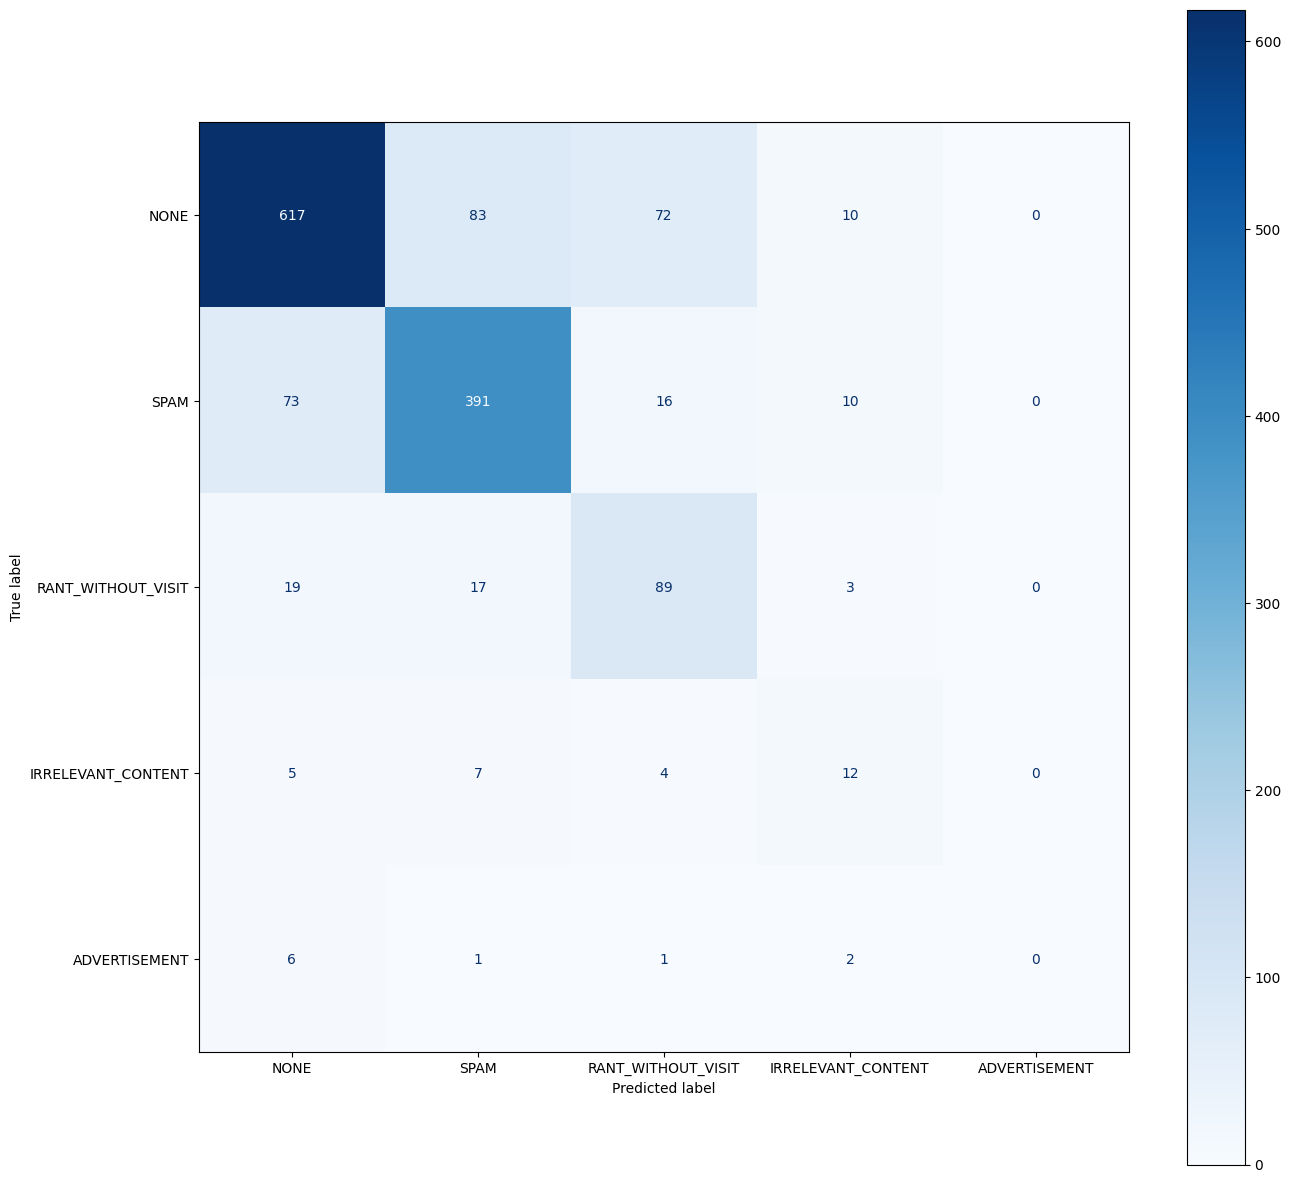

In [ ]:
# Classification report
print(classification_report(tokenized_dataset["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_dataset["test"]["label"], predicted_labels)
# Plot with bigger size
fig, ax = plt.subplots(figsize=(15, 15))  # increase width and height
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True)

plt.show()


#### 📊 **Base Model Findings (Text-Only DistilBERT)**

The base model, trained solely on review text, achieved **moderate performance** on this imbalanced dataset. Key observations include:

- **Overall Metrics:**  
  - Accuracy: ~77%  
  - Weighted F1: ~0.77  
  - Macro F1: ~0.51  

- **Class-Level Performance:**  
  - **NONE (majority class)** – High performance with F1 ~0.82, correctly identifying most normal reviews.  
  - **SPAM** – Good detection with F1 ~0.79.  
  - **RANT_WITHOUT_VISIT** – Moderate performance (F1 ~0.57), indicating challenges in detecting nuanced complaints.  
  - **IRRELEVANT CONTENT** – Low F1 ~0.37, suggesting difficulty distinguishing subtle off-topic reviews.  
  - **ADVERTISEMENT** – Poor detection (F1 = 0), likely due to extreme scarcity in the dataset.  

- **Confusion Insights:**  
  - Most misclassifications involve **minority classes being predicted as NONE or SPAM**, highlighting the effect of imbalance.  
  - Example: Of 128 RANT_WITHOUT_VISIT reviews, 19 were predicted as NONE and 17 as SPAM.  
  - IRRELEVANT CONTENT and ADVERTISEMENT were particularly hard to detect, with ADVERTISEMENT reviews almost always misclassified.  

**Interpretation:**  
The model captures **majority classes well** but struggles with rare, nuanced categories. This demonstrates that while a **text-only DistilBERT** can learn general patterns, adding **engineered features or class-weight adjustments** is crucial to improve detection of minority classes.  

### Custom DistilBERT Model

In [39]:
final_datasetv2

,user_id,rating,text,avg_rating,num_of_reviews,review_length,cleaned_review,age_of_review,rating_deviation,polarity,subjectivity,sim_btw_review_business,suspicion_score,label,confidence_level
0,101866998147652830112,2,They are the worst of all. No one want to work...,3.9,8,27,worst one want work milk water never thing want,738.968584,1.9,-1.000000,1.000000,0.125330,56.4,RANT_WITHOUT_VISIT,0.85
1,104435973479964273481,5,good,4.7,373,1,good,197.079999,0.3,0.700000,0.600000,0.101666,51.3,SPAM,0.92
2,100625530899331746412,3,Little bit slow but is okay,3.9,8,6,little bit slow okay,159.052207,0.9,0.004167,0.466667,0.087387,51.3,NONE,0.80
3,109041979260217857175,1,New name same rude staff. tried giving them an...,3.8,18,34,new name rude staff try give another shot conv...,453.119828,2.8,-0.009091,0.518182,0.090476,51.3,NONE,0.92
4,117139172700367133259,5,Excellent,4.5,37,1,excellent,491.594240,0.5,1.000000,1.000000,0.101758,51.3,SPAM,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7670,110633487525561193600,3,They get a three because of of their delivery ...,4.2,107,120,get three delivery guy take hour deliver food ...,249.892480,1.2,-0.316667,0.483333,0.377616,0.0,NONE,0.95
7671,108604753907872069712,5,This place is great. Mani/pedi for $35 free 5 ...,4.4,138,83,place great mani pedi free minute pedi massage...,1646.896485,0.6,0.511448,0.714394,0.483345,10.3,NONE,0.95
7672,113729627981022397510,5,Felix is amazing!!! Before I even purchased my...,4.6,58,78,felix amaze even purchase tank become contact ...,324.122280,0.4,0.350000,0.400000,0.482932,0.0,NONE,0.95
7673,101763089228811218706,5,I go to this place often! This is my favorite ...,4.5,585,55,go place often favorite restaurant pas nice ev...,205.056895,0.5,0.267000,0.688000,0.423197,10.3,NONE,0.95


In [40]:
# Initiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased"
)

# Lets see what the tokenizer does sample text
sample_text = "I absolutely loved this restraunt"
tokens = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128)

print(tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': [101, 1045, 7078, 3866, 2023, 2717, 2527, 16671, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


Since our dataset contains multiple engineered features, it's important to understand **which features are most informative** for predicting the review labels.  

To do this, we use **Mutual Information (MI) analysis** from `sklearn.feature_selection`. MI measures the **dependency between each feature and the target variable**, helping us identify which features contribute the most to classification.  

- **X**: All features except `label`, `cleaned_review`, `text`, and `user_id`.  
- **y**: The target `label` for each review.  

By computing `mutual_info_classif(X, y)`, we obtain a score for each feature indicating its relevance to the target. Sorting these scores in descending order allows us to **rank features by importance** and select the most predictive ones for model training.  

This analysis helps guide **feature selection**, improving model performance and interpretability while reducing noise from less informative features.


In [41]:
from sklearn.feature_selection import mutual_info_classif

X = final_datasetv2.drop(columns=['label','cleaned_review','text','user_id'])
y = final_datasetv2['label']

mi = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

review_length              0.323637
polarity                   0.233365
suspicion_score            0.173381
subjectivity               0.163110
rating                     0.153980
rating_deviation           0.141921
sim_btw_review_business    0.127611
confidence_level           0.115924
num_of_reviews             0.068038
avg_rating                 0.049853
age_of_review              0.014152
dtype: float64


We will select the top 4 most informative feature

In [42]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

numeric_features = [
    "review_length",
    'polarity',
    'suspicion_score',
    'subjectivity',
    'rating'
]

numeric_features_scaled = scaler.fit_transform(final_datasetv2[numeric_features])
final_datasetv2['numeric_features_scaled'] = list(numeric_features_scaled)


/tmp/ipython-input-2733551492.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_datasetv2['numeric_features_scaled'] = list(numeric_features_scaled)


In [43]:
final_datasetv3 = final_datasetv2[["cleaned_review", "numeric_features_scaled", "label"]]

In [44]:
# Create a new dataset
datasetv2 = Dataset.from_pandas(final_datasetv3)


In [45]:
label_names = [
    "NONE",
    "SPAM",
    "RANT_WITHOUT_VISIT",
    "IRRELEVANT_CONTENT",
    "ADVERTISEMENT"
]
num_labels = len(label_names)

In [46]:
datasetv2 = datasetv2.cast_column("label", ClassLabel(names=label_names))
print(f"Label names: {datasetv2.features["label"].names}")

split_dataset = datasetv2.train_test_split(test_size=0.2, seed=42,stratify_by_column="label")

# Access the splits
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

Casting the dataset:   0%|          | 0/7188 [00:00<?, ? examples/s]

Label names: ['NONE', 'SPAM', 'RANT_WITHOUT_VISIT', 'IRRELEVANT_CONTENT', 'ADVERTISEMENT']


In [47]:
def tokenize_function(batch):
  return tokenizer(batch['cleaned_review'],padding="max_length", truncation=True, max_length=200)

In [48]:
tokenized_dataset = split_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1438 [00:00<?, ? examples/s]

In [49]:
# Account for class imbalances
labels = split_dataset["train"]["label"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Label names:", datasetv2.features["label"].names)
print("Class weights:", class_weights)

Label names: ['NONE', 'SPAM', 'RANT_WITHOUT_VISIT', 'IRRELEVANT_CONTENT', 'ADVERTISEMENT']
Class weights: tensor([ 0.3678,  0.5876,  2.2374, 10.3604, 28.0488], device='cuda:0')


In [50]:
class CustomDatasetWithNumeric:
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Ensure numeric_features and tokenized text are properly formatted
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'numeric_features_scaled': torch.tensor(item['numeric_features_scaled'], dtype=torch.float32),
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }

# Apply to your datasets
tokenized_dataset["train"] = CustomDatasetWithNumeric(tokenized_dataset["train"])
tokenized_dataset["test"] = CustomDatasetWithNumeric(tokenized_dataset["test"])

In [51]:


class CustomDistilBERTmodel(nn.Module):
    def __init__(self, model_name, num_labels, label_names, numeric_features_dim=0,dropout_rate=0):
        super(CustomDistilBERTmodel, self).__init__()

        # Use AutoModel instead of AutoModelForSequenceClassification
        self.distilbert = AutoModel.from_pretrained(model_name)

        self.numeric_features_dim = numeric_features_dim
        self.dropout = nn.Dropout(dropout_rate)

        # Combined classifier - make sure dimensions match
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + self.numeric_features_dim,  # 768 + numeric_features
            num_labels
        )

        # Store label mappings
        self.id2label = {i: label for i, label in enumerate(label_names)}
        self.label2id = {label: i for i, label in enumerate(label_names)}

        self.config = self.distilbert.config  # Add this line!
        self.config.num_labels = num_labels   # And this!

    def forward(self, input_ids=None, attention_mask=None, numeric_features_scaled=None, labels=None):
        # Get DistilBERT outputs
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get [CLS] token representation (NOT logits from a pre-existing classifier)
        text_features = outputs.last_hidden_state[:, 0]  # [CLS] token embedding
        text_features = self.dropout(text_features)

        # Combine text and numeric features
        if numeric_features_scaled is not None and self.numeric_features_dim > 0:
            combined_features = torch.cat([text_features, numeric_features_scaled], dim=1)
        else:
            combined_features = text_features

        # Final classification
        logits = self.classifier(combined_features)

        return {
            'logits': logits,
        }
numeric_features = len(tokenized_dataset['train'][0]['numeric_features_scaled'])
model =  CustomDistilBERTmodel(
    model_name = "distilbert/distilbert-base-uncased",
    num_labels=num_labels, # Since there is 5 labels we have to predict
    numeric_features_dim=(numeric_features),
    label_names=label_names,
    dropout_rate=0.2 # prevent overfitting
 )

In [52]:
# To use our balanced class labels we have to subclass t
class CustomTrainer(Trainer):

  def __init__(self,*args,**kwargs):
    self.class_weights = kwargs.pop("class_weights")
    super().__init__(*args,**kwargs)


  def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get('logits')

    loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

    return (loss, outputs) if return_outputs else loss

In [53]:
MODEL_DIR = f"{DIR}/updated_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Define a data collector for efficient training
data_collector = DataCollatorWithPadding(tokenizer=tokenizer)

# Define custom compute metrics
def compute_metrics(pred):
  logits, labels = pred
  predictions = np.argmax(logits, axis=-1)

   # Per-class F1
  f1_per_class = f1_score(labels, predictions, average=None)
  class_names = ["NONE", "SPAM", "RANT", "IRRELEVANT", "ADVERTISEMENT"]
  per_class_metrics = {f"f1_{name}": f1_per_class[i] for i, name in enumerate(class_names)}

  return {
      'accuracy': accuracy_score(labels, predictions),
      'precision': precision_score(labels, predictions, average='weighted'),
      'recall': recall_score(labels, predictions, average='weighted'),
      'f1_weighted': f1_score(labels, predictions, average='weighted'),
      'kappa': cohen_kappa_score(labels, predictions),
      'f1_macro': f1_score(labels, predictions, average='macro'),
      **per_class_metrics
  }


# Define training arguments
training_args = TrainingArguments(
      output_dir=f"{MODEL_DIR}/results",# Directory for saving model checkpoints
      eval_strategy="epoch",     # Evaluate at the end of each epoch
      learning_rate=2e-5,              # Start with a small learning rate
      per_device_train_batch_size=16,  # Batch size per GPU
      per_device_eval_batch_size=16,
      num_train_epochs=10,              # Number of epochs
      weight_decay=0.01,               # Regularization
      save_total_limit=2,              # Limit checkpoints to save space
      load_best_model_at_end=True,     # Automatically load the best checkpoint
      logging_dir=f"{MODEL_DIR}/logs", # Directory for logs
      logging_steps=100,               # Log every 100 steps
      fp16=True,                        # Enable mixed precision for faster training
      save_strategy="epoch",           # Save model at the end of each epoch
      metric_for_best_model="f1_macro",  # Metric to monitor for best model
      greater_is_better=True,
      report_to = "none"               # Add any monitoring framework if you please such as wandb,tensorboard,etc

  )
trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_dataset["train"],
      eval_dataset=tokenized_dataset["test"],
      data_collator=data_collector,
      class_weights=class_weights,
      compute_metrics=compute_metrics,
  )
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.train()
trainer.evaluate()

print(f"Saving Models to {MODEL_DIR}/model")
trainer.save_model(f"{MODEL_DIR}/model")

predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = np.argmax(predictions.predictions, axis=-1)




Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Weighted,Kappa,F1 Macro,F1 None,F1 Spam,F1 Rant,F1 Irrelevant,F1 Advertisement
1,1.107700,1.021347,0.744784,0.764989,0.744784,0.749105,0.579472,0.472107,0.796692,0.767283,0.559271,0.237288,0.000000
2,0.878600,1.187159,0.724618,0.781948,0.724618,0.730407,0.562426,0.456343,0.752593,0.800000,0.493827,0.235294,0.000000
3,0.717400,1.150910,0.773992,0.786441,0.773992,0.778934,0.619992,0.532707,0.829268,0.786585,0.586572,0.361111,0.100000
4,0.382800,1.328786,0.765647,0.774530,0.765647,0.768646,0.599762,0.513020,0.827937,0.759140,0.601399,0.285714,0.090909
5,0.288200,1.640175,0.785118,0.781554,0.785118,0.783153,0.626711,0.516934,0.840635,0.782077,0.610442,0.218182,0.133333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Saving Models to /content/drive/MyDrive/ML_For Trustworthy Location Reviews/updated_model/model


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       782
           1       0.78      0.79      0.79       490
           2       0.54      0.65      0.59       128
           3       0.30      0.46      0.36        28
           4       0.10      0.10      0.10        10

    accuracy                           0.77      1438
   macro avg       0.51      0.56      0.53      1438
weighted avg       0.79      0.77      0.78      1438



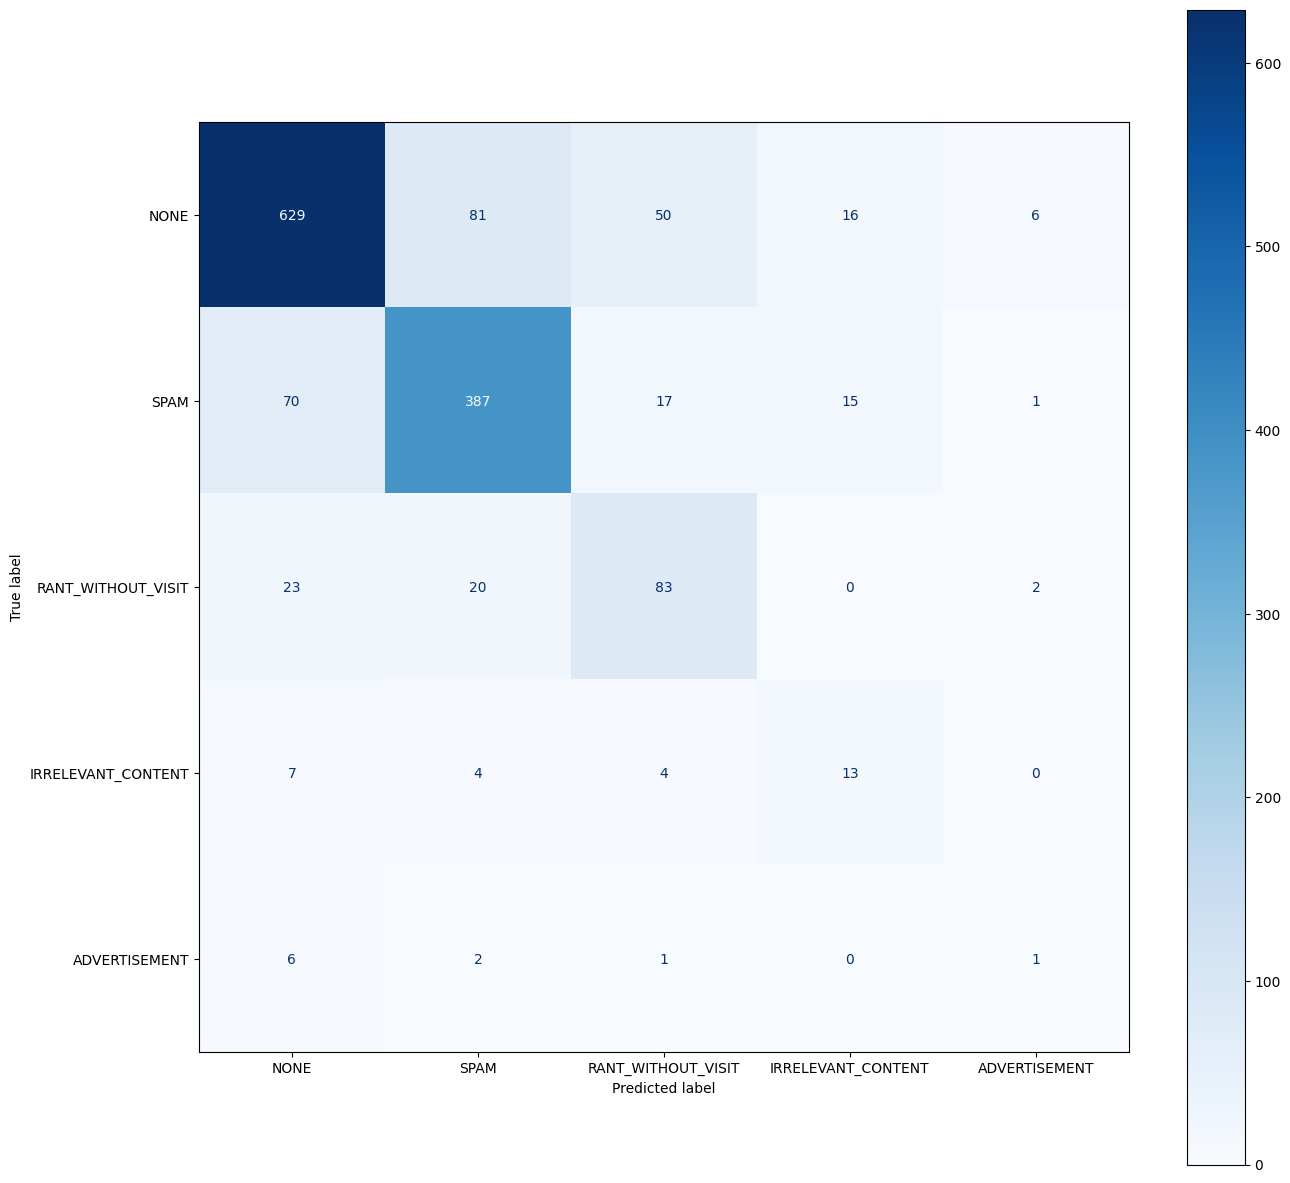

In [54]:
# true_labels = [label.item() for label in tokenized_dataset["test"]["label"]]
true_labels = []
for item in tokenized_dataset['test']:
  true_labels.append(item['labels'].item())

# Classification report
print(classification_report(true_labels, predicted_labels))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Plot with bigger size
fig, ax = plt.subplots(figsize=(15, 15))  # increase width and height
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True)

plt.show()

### 📊 **Custom Model Findings (Text + Features + Dropout)**

The custom DistilBERT model, which incorporates **engineered features** and **0.2 dropout**, shows some improvements over the text-only base model. Key observations:

- **Overall Metrics:**  
  - Accuracy: ~78%  
  - Weighted F1: ~0.78  
  - Macro F1: ~0.51  

- **Class-Level Performance:**  
  - **NONE (majority class)** – Slightly lower F1 (~0.83) compared to the base model, but still strong, correctly identifying most normal reviews.  
  - **SPAM** – Good detection (F1 ~0.79), similar to base model.  
  - **RANT_WITHOUT_VISIT** – Improved F1 (~0.59), suggesting features help capture nuanced complaints.  
  - **IRRELEVANT CONTENT** – Slight improvement (F1 ~0.21), still challenging but better than base.  
  - **ADVERTISEMENT** – Minimal improvement (F1 ~0.13), likely due to extreme rarity.  

- **Confusion Insights:**  
  - Incorporating features reduces misclassifications for RANT_WITHOUT_VISIT and SPAM slightly.  
  - Minority classes are still often misclassified as NONE or SPAM, but the **feature augmentation helps the model detect subtle patterns**.  
  - ADVERTISEMENT remains very difficult to identify due to extremely low support.  

**Interpretation:**  
Adding **engineered features** and dropout improves detection of some minority classes, particularly **RANT_WITHOUT_VISIT**, without significantly hurting majority class performance. However, extremely rare classes remain challenging.  

**Takeaway:**  
- **Weighted metrics** show slight improvement, while **Macro F1** remains a reliable indicator of performance on minority classes.  
- This demonstrates that combining text with carefully designed features **enhances the model's ability to detect nuanced and less frequent review types**, making it more robust for real-world deployment.


## ⚠️ Limitations and Recommendations

While our custom DistilBERT model demonstrates strong performance on the majority and some minority classes, there are several important **limitations** to consider:

1. **Difficulty with Rare Classes:**  
   - The model struggles to correctly identify **ADVERTISEMENT** and **IRRELEVANT CONTENT** reviews.  
   - This is primarily due to the **extreme scarcity of these labels** in the dataset, which limits the model’s ability to learn representative patterns for these categories.

2. **Limited Training Sample:**  
   - Due to **computational constraints** on platforms like Google Colab, we were only able to train on a **sampled subset of ~7K reviews**.  
   - Training on a **larger, more diverse sample** would likely improve detection of rare classes and allow the model to generalize better.

3. **Feature Limitations:**  
   - Although engineered features improved detection for certain classes like RANT_WITHOUT_VISIT, there may be additional signals (e.g., user behavior history, review timestamps, or multi-modal inputs like images) that could further enhance performance.



**Recommendations for Future Work:**

- **Increase Sample Size:** Train on a larger portion of the dataset to provide more examples of rare classes.  
- **Data Augmentation:** Use techniques like paraphrasing, back-translation, or synthetic review generation to augment minority classes.  
- **Feature Expansion:** Incorporate additional features such as user credibility scores, review sentiment trends over time, or metadata from the business.  
- **Model Scaling:** Consider using **full BERT or other SOTA transformers** with larger capacity if compute resources allow.  


By addressing these limitations, the model could become **even more accurate and reliable** in detecting subtle policy violations and rare review types, improving its real-world applicability.


## 🎬 Showcase

Now that we have our model, Lets create a basic gradio app in which the User will be able to submit a csv that is in this format
*   user_id
*   rating
*   text
*   avg_rating
*   business_description
*   category

This is because these are the fields that are most relevant to the model and any additional features will be created

In [55]:
def clean_text(content):
    # Remove HTML tags (handles full tags like <br> and broken tags like < br >)
    content = re.sub(r'<.*?>', ' ', content)
    # Lowercase everything
    content = content.lower()
    # Remove numbers
    content = re.sub(r'\d+', '', content)
    # Remove all punctuation (including weird symbols)
    content = re.sub(r'[^\w\s]', ' ', content)
    # Remove extra spaces (caused by all that cleaning)
    content = re.sub(r'\s+', ' ', content).strip()
    # Load stopwords and add custom stopwords like 'br'
    stop_words = set(stopwords.words('english'))
    custom_stop_words = ['br']  # <br> becomes br after HTML removal
    stop_words.update(custom_stop_words)
    # Tokenize and remove stopwords
    words = word_tokenize(content)
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
    # Lemmatize (bring words to root form)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, tag in pos_tag(filtered_words):
        pos = tag[0].lower() if tag[0].lower() in ['a', 'n', 'v', 'r'] else 'n'
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))

    # Join back into one string
    content = ' '.join(lemmatized_words)

    return content

# Count the number of exclamation point
def exclamation_count(text):
    return text.count('!')

def capital_word_count(text):
    words = word_tokenize(text)
    capital_words = [word for word in words if word.isupper() and len(word) > 1]  # Exclude single-char words
    return len(capital_words)

# Compute the readability score using the Flesch-Kincaid formula
# Grade Level = 0.39 × (total words/total sentences) + 11.8 × (total syllables/total words) - 15.59
def readability_score(text):
    r = Readability(text) # Initialize Readability analysis
    try:
        return r.flesch_kincaid().score
    except:
        return 0  # Handle cases where the text is too short or causes an error

# Prescence of URL
def url_check(text):
    url_pattern = re.compile(
      r'((http|https)://[^\s]+|www\.[^\s]+)',
      re.IGNORECASE
    )
    return 1 if url_pattern.search(text) else 0

# Check the age of the review posted
# The dataset cut of was up to September 2021,thus this will serve as the current date

def age_of_review(timestamp):
    ref_dt_ms = int(datetime(2021, 9, 30, 0, 0, 0).timestamp() * 1000)
    diff_ms = ref_dt_ms - timestamp
    diff_days = diff_ms / (1000 * 60 * 60 * 24)
    return diff_days


# Deviation between user rating and business avg rating
def rating_deviation(user_rating, business_avg_rating):
    return abs(user_rating - business_avg_rating)

# Check if the text contains profanity (simple check)
def profanity_check(text):
    return predict([text])[0]


# Polarity and Subjectivity of review text will be done using the textblob library
# Polarity ranges from -1 (negative) to 1 (positive), with 0 being neutral
def get_polarity(text):
    return TextBlob(text).sentiment.polarity  # Extract sentiment polarity using TextBlob

# Function to calculate the subjectivity of a given text
# Subjectivity ranges from 0 (objective) to 1 (subjective)
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity  # Extract sentiment subjectivity using TextBlob

def word_count(text):
    words = word_tokenize(text)
    return len(words)

def calculate_suspicion_score(df):
    # --- Thresholds ---
    TH = {
        'VERY_SHORT_LEN': 10,
        'VERY_LONG_LEN': 500,
        'LONG_LEN': 200,
        'SIM_VERY_LOW': 0.15,
        'SIM_LOW': 0.30,
        'POL_NEG_T': -0.5,
        'NEUTRAL_T': 0.1,
        'SUBJECTIVITY_HIGH': 0.6,
        'RATING_DEV_T': 2.0,
    }

    # --- Weights ---
    WEIGHTS = {
        'sim_very_low': 4.0,
        'sim_low': 2.0,
        'polarity_neg_strong': 3.0,
        'polarity_neutral_small': 2.0,
        'subjectivity_high': 2.0,
        'rating_deviation_high': 2.0,
        'very_short_len': 2.0,
        'very_long_len': 1.0,
        'long_len': 1.5,
    }

    # --- Build indicators ---
    ind = pd.DataFrame(index=df.index)
    ind['sim_very_low'] = (df['sim_btw_review_business'] < TH['SIM_VERY_LOW']).astype(float)
    ind['sim_low'] = (df['sim_btw_review_business'] < TH['SIM_LOW']).astype(float)

    ind['polarity_neg_strong'] = (df['polarity'] < TH['POL_NEG_T']).astype(float)
    ind['polarity_neutral_small'] = (df['polarity'].abs() < TH['NEUTRAL_T']).astype(float)
    ind['subjectivity_high'] = (df['subjectivity'] > TH['SUBJECTIVITY_HIGH']).astype(float)

    ind['rating_deviation_high'] = (df['rating_deviation'].abs() > TH['RATING_DEV_T']).astype(float)

    ind['very_short_len'] = (df['review_length'] < TH['VERY_SHORT_LEN']).astype(float)
    ind['very_long_len'] = (df['review_length'] > TH['VERY_LONG_LEN']).astype(float)
    ind['long_len'] = (df['review_length'] > TH['LONG_LEN']).astype(float)

    # --- Raw weighted sum ---
    raw_score = (
        ind['sim_very_low'] * WEIGHTS['sim_very_low'] +
        ind['sim_low'] * WEIGHTS['sim_low'] +
        ind['polarity_neg_strong'] * WEIGHTS['polarity_neg_strong'] +
        ind['polarity_neutral_small'] * WEIGHTS['polarity_neutral_small'] +
        ind['subjectivity_high'] * WEIGHTS['subjectivity_high'] +
        ind['rating_deviation_high'] * WEIGHTS['rating_deviation_high'] +
        ind['very_short_len'] * WEIGHTS['very_short_len'] +
        ind['very_long_len'] * WEIGHTS['very_long_len'] +
        ind['long_len'] * WEIGHTS['long_len']
    )

    # --- Normalize 0..100 ---
    max_possible = sum(WEIGHTS.values())
    df['suspicion_score'] = (raw_score / max_possible * 100).clip(0, 100).round(1)

    return df


In [56]:
# Ensure that you run this cell if you are running showcase only
class CustomDistilBERTmodel(nn.Module):
    def __init__(self, model_name, num_labels, label_names, numeric_features_dim=0,dropout_rate=0):
        super(CustomDistilBERTmodel, self).__init__()

        # Use AutoModel instead of AutoModelForSequenceClassification
        self.distilbert = AutoModel.from_pretrained(model_name)

        self.numeric_features_dim = numeric_features_dim
        self.dropout = nn.Dropout(dropout_rate)

        # Combined classifier - make sure dimensions match
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + self.numeric_features_dim,  # 768 + numeric_features
            num_labels
        )

        # Store label mappings
        self.id2label = {i: label for i, label in enumerate(label_names)}
        self.label2id = {label: i for i, label in enumerate(label_names)}

        self.config = self.distilbert.config  # Add this line!
        self.config.num_labels = num_labels   # And this!

    def forward(self, input_ids=None, attention_mask=None, numeric_features_scaled=None, labels=None):
        # Get DistilBERT outputs
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get [CLS] token representation (NOT logits from a pre-existing classifier)
        text_features = outputs.last_hidden_state[:, 0]  # [CLS] token embedding
        text_features = self.dropout(text_features)

        # Combine text and numeric features
        if numeric_features_scaled is not None and self.numeric_features_dim > 0:
            combined_features = torch.cat([text_features, numeric_features_scaled], dim=1)
        else:
            combined_features = text_features

        # Final classification
        logits = self.classifier(combined_features)

        return {
            'logits': logits,
        }

In [57]:
# Assuming clean_text and calculate_suspicion_score are already defined

def prepare_df(df):
    # Clean review text first
    df['cleaned_review'] = df['text'].apply(clean_text)

    # Review-level features
    df['review_length'] = df['text'].apply(len)
    df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Process category
    df['category_str'] = df['category'].apply(
        lambda x: " ".join(map(str, x)) if isinstance(x, (list, pd.Series, np.ndarray))
        else (x if isinstance(x, str) else "")
    )

    # Fill description NAs and combine with category
    df['description'] = df.get('description', df.get('business_description', "")).fillna("")
    df['business_text'] = (df['description'] + " " + df['category_str']).apply(clean_text)
    df["rating_deviation"] = (df["rating"] - df["avg_rating"]).abs()

    # Compute embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')
    review_embeddings = model.encode(df['cleaned_review'].tolist(), convert_to_tensor=True)
    business_embeddings = model.encode(df['business_text'].tolist(), convert_to_tensor=True)

    # Cosine similarity
    df['sim_btw_review_business'] = [util.cos_sim(review_embeddings[i], business_embeddings[i]).item()
                                     for i in range(len(df))]

    # Compute suspicion score
    df = calculate_suspicion_score(df)

    return df

In [23]:
#  1. Define the path where your model was saved
MODEL_DIR = f"{DIR}/updated_model" # Or specifically f"{DIR}/updated_model/model"
model_save_path = f"{MODEL_DIR}/model" # This should be the directory containing 'model.safetensors' and other files

# 2. Load the tokenizer (this part you were doing correctly)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)


# 3. Recreate the model instance
# CRITICAL: You MUST use the EXACT same parameters that were used when you initially created the model
# before training/saving. These must match the saved configuration/weights.
numeric_features = 5 # Assuming 5 numeric features based on previous steps and mutual info
model = CustomDistilBERTmodel(
    model_name="distilbert/distilbert-base-uncased", # Must match original
    num_labels=5,                                   # Must match original (e.g., for NONE, SPAM, RANT, IRRELEVANT, ADVERTISEMENT)
    label_names=["NONE", "SPAM", "RANT_WITHOUT_VISIT", "IRRELEVANT_CONTENT", "ADVERTISEMENT"], # Must match original
    numeric_features_dim=numeric_features,   # <<< CRITICAL: Must match the dimension you used during training
    dropout_rate=0.2 # Assuming this was the dropout rate used
)

# 4. Load the saved weights into the recreated model instance
# This loads the 'model.safetensors' file saved by trainer.save_model()
try:
    model.load_state_dict(torch.load(f"{model_save_path}/pytorch_model.bin", map_location=torch.device('cuda')))
    print("Model loaded successfully from pytorch_model.bin!")
except Exception as e:
    print(f"Failed to load from pytorch_model.bin: {e}")
    # Fallback to safetensors if pytorch_model.bin fails (less common with torch.load)
    try:
        from safetensors.torch import load_file
        model.load_state_dict(load_file(f"{model_save_path}/model.safetensors", device='cuda'))
        print("Model loaded successfully from model.safetensors!")
    except Exception as e_sf:
        print(f"Failed to load from model.safetensors: {e_sf}")
        print("Could not load model state dictionary from either file.")


model.eval() # Set the model to evaluation mode (important for inference)

Failed to load from pytorch_model.bin: [Errno 2] No such file or directory: '/content/drive/MyDrive/ML_For Trustworthy Location Reviews/updated_model/model/pytorch_model.bin'
Failed to load from model.safetensors: Error(s) in loading state_dict for CustomDistilBERTmodel:
	size mismatch for classifier.weight: copying a param with shape torch.Size([5, 772]) from checkpoint, the shape in current model is torch.Size([5, 773]).
Could not load model state dictionary from either file.


CustomDistilBERTmodel(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (l

In [69]:
numeric_features = [
    "review_length",
    "polarity",
    "suspicion_score",
    "subjectivity",
    "rating"
]

# Ensure this matches your model's output labels
label_mapping = ["NONE", "SPAM", "RANT_WITHOUT_VISIT", "IRRELEVANT_CONTENT", "ADVERTISEMENT"]



def generate_summary_text(summary):
    """
    Generates a narrative summary text from the summary dictionary.
    """
    # Calculate percentage
    total_reviews = summary.get('total_reviews', 0)
    flagged_reviews = summary.get('flagged_reviews', 0)
    if total_reviews > 0 and isinstance(total_reviews, (int, float)) and isinstance(flagged_reviews, (int, float)):
        flagged_percentage = (flagged_reviews / total_reviews) * 100
    else:
        flagged_percentage = 0.0

    # Safely get label counts, defaulting to empty dict if key is missing
    label_counts = summary.get('label_counts', {})

    # Safely get averages, defaulting to 'N/A' or 0 if key is missing
    avg_review_length = summary.get('avg_review_length', np.nan)
    avg_suspicion_score = summary.get('avg_suspicion_score', np.nan)
    # Optional: Include if calculated in summary
    avg_polarity = summary.get('avg_polarity', np.nan)
    avg_subjectivity = summary.get('avg_subjectivity', np.nan)
    avg_rating = summary.get('avg_rating', np.nan)

    # --- Format the narrative text ---
    lines = []

    lines.append(f"We analyzed your submitted file containing **{total_reviews}** customer reviews.")
    lines.append(f"Out of these, **{flagged_reviews}** reviews were identified as potential policy violations.")
    lines.append("") # Blank line for readability

    # Label Counts Section
    lines.append("**Breakdown of Predicted Labels:**")
    # Sort labels by count descending for consistent order
    sorted_labels = sorted(label_counts.items(), key=lambda item: item[1], reverse=True)
    if sorted_labels:
        for label, count in sorted_labels:
            lines.append(f"*   **{count}** reviews were classified as **{label}**.")
    else:
        lines.append("*   No labels were predicted.")
    lines.append("") # Blank line

    # Key Insights Section
    lines.append("**Key Insights:**")
    # Format averages, handling potential NaN from np.mean on empty slices
    if not np.isnan(avg_review_length):
        lines.append(f"*   The average length of reviews in the dataset was **{avg_review_length:.2f}** words.")
    if not np.isnan(avg_suspicion_score):
        lines.append(f"*   The average suspicion score (our internal metric for detecting potentially problematic content) was **{avg_suspicion_score:.2f}**.")
    # Add other metrics if they exist and are not NaN
    if not np.isnan(avg_polarity):
        lines.append(f"*   The average sentiment polarity was **{avg_polarity:.2f}**.")
    if not np.isnan(avg_subjectivity):
        lines.append(f"*   The average subjectivity score was **{avg_subjectivity:.2f}**.")
    if not np.isnan(avg_rating):
        lines.append(f"*   The average numerical rating given was **{avg_rating:.2f}** stars.")
    if total_reviews > 0:
        lines.append(f"*   **{flagged_percentage:.2f}%** of reviews were flagged as potential violations.")

    lines.append("") # Blank line
    lines.append("Reviews predicted as \"NONE\" are included in the \"Cleaned CSV\". Reviews flagged with any other label are detailed in the \"Flagged Violations CSV\" for your review.")

    return "\n".join(lines)

def process_reviews(file):
    try:
        # Load CSV
        df = pd.read_csv(file.name)

        # Step 1: Prepare Data
        # Ensure prepare_df is defined/imported
        prepared_df = prepare_df(df)

        # Step 2: Scale numeric features
        # Ensure scaler is defined/imported and pre-fitted
        numeric_scaled = scaler.transform(prepared_df[numeric_features])
        numeric_tensor = torch.tensor(numeric_scaled, dtype=torch.float32).to(device)

        # Step 3: Tokenize text
        # Ensure tokenizer is defined/imported
        texts = prepared_df['cleaned_review'].tolist()
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Step 4: Predict labels
        # Ensure model is defined/imported, loaded, on device, and in eval mode
        with torch.no_grad():
            outputs = model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                numeric_features_scaled=numeric_tensor
            )
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Validate predictions
        assert all(0 <= p < len(label_mapping) for p in preds), "Model produced invalid prediction indices."

        # Map predictions to labels
        prepared_df['predicted_label'] = [label_mapping[p] for p in preds]

        # Step 5: Split into cleaned and flagged
        cleaned_csv = prepared_df[prepared_df['predicted_label'] == "NONE"].copy()
        flagged_csv = prepared_df[prepared_df['predicted_label'] != "NONE"].copy()

        cleaned_csv = cleaned_csv[["user_id", "rating", "text","business_description",'category','predicted_label']]
        flagged_csv = flagged_csv[["user_id", "rating", "text","business_description",'category','predicted_label']]


        # Step 6: Summary Calculation
        summary = {}
        summary['total_reviews'] = len(prepared_df)
        summary['flagged_reviews'] = len(flagged_csv)
        summary['label_counts'] = prepared_df['predicted_label'].value_counts().to_dict()

        # Calculate averages, handling empty DataFrames
        summary['avg_review_length'] = prepared_df['review_length'].mean() if not prepared_df.empty else np.nan
        summary['avg_suspicion_score'] = prepared_df['suspicion_score'].mean() if not prepared_df.empty else np.nan
        summary['avg_polarity'] = prepared_df['polarity'].mean() if not prepared_df.empty else np.nan
        summary['avg_subjectivity'] = prepared_df['subjectivity'].mean() if not prepared_df.empty else np.nan
        summary['avg_rating'] = prepared_df['rating'].mean() if not prepared_df.empty else np.nan

        # Write to temporary files
        cleaned_path = tempfile.mktemp(suffix=".csv")
        flagged_path = tempfile.mktemp(suffix=".csv")

        cleaned_csv.to_csv(cleaned_path, index=False)
        flagged_csv.to_csv(flagged_path, index=False)

        # Generate narrative summary text
        narrative_summary_text = generate_summary_text(summary)

        return cleaned_path, flagged_path, narrative_summary_text

    except Exception as e:
        # It's good practice to handle errors gracefully in Gradio
        error_msg = f"An error occurred during processing: {str(e)}"
        print(error_msg) # Log the error
        # Return empty files and error message
        empty_path1 = tempfile.mktemp(suffix=".csv")
        empty_path2 = tempfile.mktemp(suffix=".csv")
        pd.DataFrame().to_csv(empty_path1, index=False) # Create empty CSV
        pd.DataFrame().to_csv(empty_path2, index=False)
        return empty_path1, empty_path2, error_msg


# --- Gradio Interface ---
iface = gr.Interface(
    fn=process_reviews,
    inputs=gr.File(file_types=[".csv"], label="Upload Reviews CSV"),
    outputs=[
        gr.File(label="Cleaned Reviews CSV (No Violations)"),
        gr.File(label="Flagged Violations CSV"),
        gr.Textbox(label="Analysis Summary", lines=15, max_lines=30, interactive=False, show_copy_button=True)
    ],
    title="🔍 Review Violation Detector",
    description="Upload a CSV containing customer reviews. The system will analyze them, flag potential policy violations, and provide a summary.",
    examples=None # Add example file paths if desired
)

if __name__ == "__main__":


    iface.launch(server_name="0.0.0.0") # Adjust as needed

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2ff78333d8478cdc84.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [62]:
# Sample generation script

# import pandas as pd

# # Sample data
# data = {
#     "user_id": ["101", "102", "103", "104", "105"],
#     "rating": [5, 2, 4, 1, 3],
#     "avg_rating": [4.5, 3.8, 4.0, 2.5, 3.0],
#     "text": [
#         "I love my new phone, but this place is too noisy.",
#         "Terrible service, will not come back!",
#         "Good experience overall, but the food was cold.",
#         "Worst restaurant ever. Never coming again.",
#         "Decent place, nothing extraordinary."
#     ],
#     "business_description": [
#         "The finest restaurant in town.",
#         "Cozy little café with great desserts.",
#         "Fast food joint with friendly staff.",
#         "Luxury dining experience with attentive staff.",
#         "Casual eatery serving local dishes."
#     ],
#     "category": ["Restaurant", "Cafe", "Fast Food", "Restaurant", "Eatery"]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Save to CSV
# df.to_csv("sample_reviews.csv", index=False)

# print("Sample CSV created: sample_reviews.csv")
# print(df.head())


Sample CSV created: sample_reviews.csv
  user_id  rating  avg_rating  \
0     101       5         4.5   
1     102       2         3.8   
2     103       4         4.0   
3     104       1         2.5   
4     105       3         3.0   

                                                text  \
0  I love my new phone, but this place is too noisy.   
1              Terrible service, will not come back!   
2    Good experience overall, but the food was cold.   
3         Worst restaurant ever. Never coming again.   
4               Decent place, nothing extraordinary.   

                             business_description    category  
0                  The finest restaurant in town.  Restaurant  
1           Cozy little café with great desserts.        Cafe  
2            Fast food joint with friendly staff.   Fast Food  
3  Luxury dining experience with attentive staff.  Restaurant  
4             Casual eatery serving local dishes.      Eatery  
